## Daily Data

SF and MX decompositions for one year of data (output096) 

**Full computation steps shown here, some performed in PBS scripts (`save_10daily_quantities_xhistogram.py,save_1daily_quantities_xhistogram.py`)**


In [1]:
#Load required packages
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
from xgcm import Grid
import numpy as np
import pandas as pd
import cftime
import IPython.display
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
import sys, os
import warnings
warnings.simplefilter("ignore")
from dask.distributed import Client

from xhistogram.xarray import histogram


In [2]:
client = Client(n_workers=8)
client

<Client: 'tcp://127.0.0.1:34321' processes=8 threads=16, memory=250.00 GiB>

In [3]:
# files:
base = '/scratch/e14/cy8964/access-om2/archive/025deg_jra55_ryf/';
xch = 1440#2*288
ych = 1080#2*216

fgrd   = xr.open_dataset(base + 'output096/ocean/ocean_grid.nc').chunk({'yt_ocean':ych,'yu_ocean':ych,'xt_ocean':xch,'xu_ocean':xch})
fwmass_mean = xr.open_mfdataset('/scratch/e14/cy8964/temp/025deg_096/ocean_wmass_mean.nc').chunk({'grid_yt_ocean':ych,'grid_yu_ocean':ych,'grid_xt_ocean':xch})
fmonth_mean = xr.open_mfdataset('/scratch/e14/cy8964/temp/025deg_096/ocean_month_mean.nc').chunk({'yt_ocean':ych,'yu_ocean':ych,'xt_ocean':xch})
fheat_mean = xr.open_mfdataset('/scratch/e14/cy8964/temp/025deg_096/ocean_heat_mean.nc').chunk({'yt_ocean':ych,'xt_ocean':xch})

# load RYF monthly data
base_msc = '/scratch/e14/cy8964/access-om2/archive/025deg_jra55_ryf/'
# ---------------------------------------------------------------------------------- #
# load in data set ----------------------------------------------------------------- #
fmonth_m = xr.open_mfdataset(base_msc+'output096/ocean/ocean_month.nc',combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'yt_ocean':ych/10,'xt_ocean':xch/10})
fheat_m = xr.open_mfdataset(base_msc+'output096/ocean/ocean_heat.nc',combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'yt_ocean':ych/10,'xt_ocean':xch/10})
fwmass_m = xr.open_mfdataset(base_msc+'output096/ocean/ocean_wmass.nc',combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'grid_yt_ocean':ych/10,'grid_xt_ocean':xch/10})

# load RYF daily data
base_msc = '/scratch/e14/cy8964/access-om2/archive/025deg_jra55_ryf/'
# ---------------------------------------------------------------------------------- #
# load in data set ----------------------------------------------------------------- #
fdaily = xr.open_mfdataset(base_msc+'output096/ocean/ocean_daily.nc',combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'yt_ocean':ych/10,'xt_ocean':xch/10})
fheat_daily = xr.open_mfdataset(base_msc+'output096/ocean/ocean_heat_daily.nc',combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'yt_ocean':ych/10,'xt_ocean':xch/10})
fwmass_daily = xr.open_mfdataset(base_msc+'output096/ocean/ocean_wmass_daily.nc',combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'grid_yt_ocean':ych/10,'grid_xt_ocean':xch/10})

# ---------------------------------------------------------------------------------- #

# Generate xgcm grid object:
gridwm = Grid(fwmass_m,coords={"x":{"center":"grid_xt_ocean"},
                             "y":{"center":"grid_yt_ocean","right":"grid_yu_ocean"},
                             "T":{"center":"neutral","outer":"neutralrho_edges"}},periodic=False)
gridmn = Grid(fmonth_m,coords={"x":{"center":"xt_ocean"},
                             "y":{"center":"yt_ocean","right":"yu_ocean"},
                             "z":{"center":"st_ocean","outer":"st_edges_ocean"}},periodic=False)
gridht = Grid(fheat_m,coords={"x":{"center":"xt_ocean"},
                             "y":{"center":"yt_ocean"},
                             "z":{"center":"st_ocean","outer":"st_edges_ocean"}},periodic=False)
gridd = Grid(fdaily,coords={"x":{"center":"xt_ocean"},
                             "y":{"center":"yt_ocean","right":"yu_ocean"},
                             "z":{"center":"st_ocean","outer":"st_edges_ocean"}},periodic=False)

# ---------------------------------------------------------------------------------- #

# Some constants:
Cp = 3992.10322329649
rho0 = 1035
dT = (fwmass_m.neutral[1]-fwmass_m.neutral[0]).values

sc_daylength = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

area = fgrd.area_t.rename({'xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
dy = gridmn.diff(fgrd.yu_ocean,'y',boundary='extend').rename({'yt_ocean':'grid_yt_ocean'})

Define some functions

In [4]:
def running_av_2mos(variable):
    month_length = variable.time.dt.days_in_month
    running_mean = (variable*month_length).roll(time = 1, roll_coords = False)+ (variable*month_length)#.roll(time = -1, roll_coords = False)+2*(variable*month_length)
    time_length = (month_length).roll(time = 1, roll_coords = False)+ (month_length)#.roll(time = -1, roll_coords = False)+2*(month_length)
    running_mean = running_mean/time_length
    return running_mean


In [5]:
def running_av_2mos_mo(variable):
    month_length = variable.time.dt.days_in_month
    time_length = (month_length).roll(time = 1, roll_coords = False)+ (month_length)#.roll(time = -1, roll_coords = False)+2*(month_length)
    time_length = time_length/2
    return time_length


In [6]:
def weighted_time_mean_2mo_filter(variable):
    month_length = running_av_2mos_mo(variable.time.dt.days_in_month)
    time_mean = (variable*month_length).sum('time')/(month_length.sum('time'))
    return time_mean

In [7]:
def weighted_time_mean(variable):
    month_length = variable.time.dt.days_in_month
    time_mean = (variable*month_length).sum('time')/(month_length.sum('time'))
    return time_mean

In [13]:
def running_av_10days(variable):
    running_mean = (variable).roll(time = 1, roll_coords = False)+ (variable) + (variable).roll(time = 2, roll_coords = False)+ (variable).roll(time = 3, roll_coords = False)+(variable).roll(time = 4, roll_coords = False)+(variable).roll(time = 5, roll_coords = False)+(variable).roll(time = 6, roll_coords = False)+(variable).roll(time = 7, roll_coords = False)+(variable).roll(time = 8, roll_coords = False)+(variable).roll(time = 9, roll_coords = False)#.roll(time = -1, roll_coords = False)+2*(variable*month_length)
    running_mean = running_mean/10
    return running_mean


In [9]:
fheat_m.average_DT.values/3600/24/1e9

array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
      dtype='timedelta64[ns]')

#### COMPUTATION OF TIME MEANS

(same as 04-27, no need to run again)

ncra doesn't do time weighting within files. Hence, mean quantities calculated with ncra are slightly wrong (and are wrong in Ryan's original 9 year means too)

Here I calculate them manually using my weighted time mean function, and save them out.

In [11]:
# %%time
# ## correct time means of ocean_wmass.nc

# # weighted time average
# mean_ty_trans_nrho = weighted_time_mean(fwmass_m.ty_trans_nrho)
# mean_temp_vdiffuse_sbc_on_nrho = weighted_time_mean(fwmass_m.temp_vdiffuse_sbc_on_nrho)
# mean_sfc_hflux_pme_on_nrho = weighted_time_mean(fwmass_m.sfc_hflux_pme_on_nrho)
# mean_frazil_on_nrho = weighted_time_mean(fwmass_m.frazil_on_nrho)
# mean_sw_heat_on_nrho = weighted_time_mean(fwmass_m.sw_heat_on_nrho)
# mean_temp_vdiffuse_diff_cbt_on_nrho = weighted_time_mean(fwmass_m.temp_vdiffuse_diff_cbt_on_nrho)
# mean_temp_nonlocal_KPP_on_nrho = weighted_time_mean(fwmass_m.temp_nonlocal_KPP_on_nrho)

# mean_sw_heat_on_nrho = weighted_time_mean(fwmass_m.sw_heat_on_nrho)
# mean_temp_vdiffuse_diff_cbt_kppish_on_nrho = weighted_time_mean(fwmass_m.temp_vdiffuse_diff_cbt_kppish_on_nrho)
# mean_temp_vdiffuse_diff_cbt_kppicon_on_nrho = weighted_time_mean(fwmass_m.temp_vdiffuse_diff_cbt_kppicon_on_nrho)
# mean_vdiffuse_diff_cbt_kppbl_on_nrho = weighted_time_mean(fwmass_m.temp_vdiffuse_diff_cbt_kppbl_on_nrho)
# mean_temp_vdiffuse_diff_cbt_wave_on_nrho = weighted_time_mean(fwmass_m.temp_vdiffuse_diff_cbt_wave_on_nrho)
# mean_temp_vdiffuse_diff_cbt_kppdd_on_nrho = weighted_time_mean(fwmass_m.temp_vdiffuse_diff_cbt_kppdd_on_nrho)

# # load
# mean_ty_trans_nrho.load()
# mean_temp_vdiffuse_sbc_on_nrho.load()
# mean_sfc_hflux_pme_on_nrho.load()
# mean_frazil_on_nrho.load()
# mean_sw_heat_on_nrho.load()
# mean_temp_vdiffuse_diff_cbt_on_nrho.load()
# mean_temp_nonlocal_KPP_on_nrho.load()
# mean_sw_heat_on_nrho.load()
# mean_temp_vdiffuse_diff_cbt_kppish_on_nrho.load()
# mean_temp_vdiffuse_diff_cbt_kppicon_on_nrho.load()
# mean_vdiffuse_diff_cbt_kppbl_on_nrho.load()
# mean_temp_vdiffuse_diff_cbt_wave_on_nrho.load()
# mean_temp_vdiffuse_diff_cbt_kppdd_on_nrho.load()

KeyboardInterrupt: 

In [65]:
# # save to ncfile
# ds = xr.Dataset({'ty_trans_nrho': mean_ty_trans_nrho, 'temp_vdiffuse_sbc_on_nrho': mean_temp_vdiffuse_sbc_on_nrho, 
#                  'sfc_hflux_pme_on_nrho':mean_sfc_hflux_pme_on_nrho, 'frazil_on_nrho':mean_frazil_on_nrho,
#                  'sw_heat_on_nrho':mean_sw_heat_on_nrho,'temp_vdiffuse_diff_cbt_on_nrho':mean_temp_vdiffuse_diff_cbt_on_nrho,
#                  'temp_nonlocal_KPP_on_nrho':mean_temp_nonlocal_KPP_on_nrho,'temp_vdiffuse_diff_cbt_kppdd_on_nrho':mean_temp_vdiffuse_diff_cbt_kppdd_on_nrho,
#                  'sw_heat_on_nrho':mean_sw_heat_on_nrho,'temp_vdiffuse_diff_cbt_kppish_on_nrho':mean_temp_vdiffuse_diff_cbt_kppish_on_nrho,
#                  'temp_vdiffuse_diff_cbt_kppicon_on_nrho':mean_temp_vdiffuse_diff_cbt_kppicon_on_nrho,'temp_vdiffuse_diff_cbt_kppbl_on_nrho':mean_vdiffuse_diff_cbt_kppbl_on_nrho,
#                  'temp_vdiffuse_diff_cbt_wave_on_nrho':mean_temp_vdiffuse_diff_cbt_wave_on_nrho})
                 
# ds.to_netcdf('/scratch/e14/cy8964/temp/025deg_096/ocean_wmass_mean.nc', 
#          encoding={'ty_trans_nrho': {'shuffle': True, 'zlib': True, 'complevel': 5},
#                   'temp_vdiffuse_sbc_on_nrho': {'shuffle': True, 'zlib': True, 'complevel': 5},
#                   'sfc_hflux_pme_on_nrho': {'shuffle': True, 'zlib': True, 'complevel': 5},
#                   'frazil_on_nrho': {'shuffle': True, 'zlib': True, 'complevel': 5},
#                   'temp_nonlocal_KPP_on_nrho': {'shuffle': True, 'zlib': True, 'complevel': 5},
#                   'frazil_on_nrho': {'shuffle': True, 'zlib': True, 'complevel': 5},
#                   'temp_vdiffuse_diff_cbt_on_nrho': {'shuffle': True, 'zlib': True, 'complevel': 5},
#                   'sw_heat_on_nrho': {'shuffle': True, 'zlib': True, 'complevel': 5},
#                   'temp_vdiffuse_diff_cbt_kppish_on_nrho': {'shuffle': True, 'zlib': True, 'complevel': 5},
#                   'temp_vdiffuse_diff_cbt_kppicon_on_nrho': {'shuffle': True, 'zlib': True, 'complevel': 5},
#                   'temp_vdiffuse_diff_cbt_kppbl_on_nrho': {'shuffle': True, 'zlib': True, 'complevel': 5},
#                   'temp_vdiffuse_diff_cbt_kppdd_on_nrho': {'shuffle': True, 'zlib': True, 'complevel': 5},
#                   'temp_vdiffuse_diff_cbt_wave_on_nrho': {'shuffle': True, 'zlib': True, 'complevel': 5}})

In [67]:
# %%time
# ## correct time means of ocean_heat.nc

# # weighted time average
# mean_temp_vdiffuse_sbc = weighted_time_mean(fheat_m.temp_vdiffuse_sbc)
# mean_sfc_hflux_pme = weighted_time_mean(fheat_m.sfc_hflux_pme)
# mean_frazil_3d = weighted_time_mean(fheat_m.frazil_3d)
# mean_sw_heat = weighted_time_mean(fheat_m.sw_heat)
# mean_temp_vdiffuse_diff_cbt = weighted_time_mean(fheat_m.temp_vdiffuse_diff_cbt)
# mean_temp_nonlocal_KPP = weighted_time_mean(fheat_m.temp_nonlocal_KPP)

# mean_sw_heat = weighted_time_mean(fheat_m.sw_heat)
# mean_temp_vdiffuse_diff_cbt_kppish = weighted_time_mean(fheat_m.temp_vdiffuse_diff_cbt_kppish)
# mean_temp_vdiffuse_diff_cbt_kppicon = weighted_time_mean(fheat_m.temp_vdiffuse_diff_cbt_kppicon)
# mean_vdiffuse_diff_cbt_kppbl = weighted_time_mean(fheat_m.temp_vdiffuse_diff_cbt_kppbl)
# mean_temp_vdiffuse_diff_cbt_wave = weighted_time_mean(fheat_m.temp_vdiffuse_diff_cbt_wave)
# mean_temp_vdiffuse_diff_cbt_kppdd = weighted_time_mean(fheat_m.temp_vdiffuse_diff_cbt_kppdd)

# # load
# mean_temp_vdiffuse_sbc.load()
# mean_sfc_hflux_pme.load()
# mean_frazil_3d.load()
# mean_sw_heat.load()
# mean_temp_vdiffuse_diff_cbt.load()
# mean_temp_nonlocal_KPP.load()
# mean_temp_vdiffuse_diff_cbt_kppish.load()
# mean_temp_vdiffuse_diff_cbt_kppicon.load()
# mean_vdiffuse_diff_cbt_kppbl.load()
# mean_temp_vdiffuse_diff_cbt_wave.load()
# mean_temp_vdiffuse_diff_cbt_kppdd.load()

# # save to ncfile
# ds = xr.Dataset({'temp_vdiffuse_sbc': mean_temp_vdiffuse_sbc, 
#                  'sfc_hflux_pme':mean_sfc_hflux_pme, 'frazil_3d':mean_frazil_3d,
#                  'sw_heat':mean_sw_heat,'temp_vdiffuse_diff_cbt':mean_temp_vdiffuse_diff_cbt,
#                  'temp_nonlocal_KPP':mean_temp_nonlocal_KPP,'temp_vdiffuse_diff_cbt_kppdd':mean_temp_vdiffuse_diff_cbt_kppdd,
#                  'temp_vdiffuse_diff_cbt_kppish':mean_temp_vdiffuse_diff_cbt_kppish,
#                  'temp_vdiffuse_diff_cbt_kppicon':mean_temp_vdiffuse_diff_cbt_kppicon,'temp_vdiffuse_diff_cbt_kppbl':mean_vdiffuse_diff_cbt_kppbl,
#                  'temp_vdiffuse_diff_cbt_wave':mean_temp_vdiffuse_diff_cbt_wave})
                 
# ds.to_netcdf('/scratch/e14/cy8964/temp/025deg_096/ocean_heat_mean.nc', 
#          encoding={'temp_vdiffuse_sbc': {'shuffle': True, 'zlib': True, 'complevel': 5},
#                   'sfc_hflux_pme': {'shuffle': True, 'zlib': True, 'complevel': 5},
#                   'frazil_3d': {'shuffle': True, 'zlib': True, 'complevel': 5},
#                   'temp_nonlocal_KPP': {'shuffle': True, 'zlib': True, 'complevel': 5},
#                   'temp_vdiffuse_diff_cbt': {'shuffle': True, 'zlib': True, 'complevel': 5},
#                   'sw_heat': {'shuffle': True, 'zlib': True, 'complevel': 5},
#                   'temp_vdiffuse_diff_cbt_kppish': {'shuffle': True, 'zlib': True, 'complevel': 5},
#                   'temp_vdiffuse_diff_cbt_kppicon': {'shuffle': True, 'zlib': True, 'complevel': 5},
#                   'temp_vdiffuse_diff_cbt_kppbl': {'shuffle': True, 'zlib': True, 'complevel': 5},
#                   'temp_vdiffuse_diff_cbt_kppdd': {'shuffle': True, 'zlib': True, 'complevel': 5},
#                   'temp_vdiffuse_diff_cbt_wave': {'shuffle': True, 'zlib': True, 'complevel': 5}})



CPU times: user 2min 6s, sys: 12.8 s, total: 2min 19s
Wall time: 3min 23s


In [68]:
# %%time
# ## correct time means of ocean_month.nc

# # weighted time average
# mean_temp = weighted_time_mean(fmonth_m.temp)
# mean_ty_trans = weighted_time_mean(fmonth_m.ty_trans)

# # load
# mean_temp.load()
# mean_ty_trans.load()

# # save to ncfile
# ds = xr.Dataset({'temp': mean_temp, 'ty_trans':mean_ty_trans, })
                 
# ds.to_netcdf('/scratch/e14/cy8964/temp/025deg_096/ocean_month_mean.nc', 
#          encoding={'temp': {'shuffle': True, 'zlib': True, 'complevel': 5},
#                   'ty_trans': {'shuffle': True, 'zlib': True, 'complevel': 5}})



CPU times: user 27.7 s, sys: 2.63 s, total: 30.3 s
Wall time: 42.9 s


### Continue Here:

In [8]:
# Group SF and MX terms for monthly data:
fwmass_m["SF_cv"] = fwmass_m.temp_vdiffuse_sbc_on_nrho + \
                       fwmass_m.sfc_hflux_pme_on_nrho + \
                       fwmass_m.frazil_on_nrho + \
                       fwmass_m.sw_heat_on_nrho# + \
#                       fwmass_m.temp_rivermix_on_nrho
fwmass_m["MX_cv"] = fwmass_m.temp_vdiffuse_diff_cbt_on_nrho + \
                       fwmass_m.temp_nonlocal_KPP_on_nrho 

obj, obj2 = xr.broadcast(fheat_m.sfc_hflux_pme,fheat_m.temp_vdiffuse_sbc)
sfc_hflux_pme_m = obj.where(fheat_m.st_ocean==fheat_m.st_ocean[0],other=0.)

fheat_m["SF_cv"] = fheat_m.temp_vdiffuse_sbc + \
                      sfc_hflux_pme_m + \
                      fheat_m.frazil_3d + \
                      fheat_m.sw_heat# + \
#                      fheat_m.temp_rivermix
fheat_m["MX_cv"] = fheat_m.temp_vdiffuse_diff_cbt + \
                      fheat_m.temp_nonlocal_KPP 
# Group SF and MX terms for daily data:

obj, obj2 = xr.broadcast(fheat_daily.sfc_hflux_pme,fheat_daily.temp_vdiffuse_sbc)
sfc_hflux_pme_daily = obj.where(fheat_daily.st_ocean==fheat_daily.st_ocean[0],other=0.)

fheat_daily["MX_cv"] = fheat_daily.temp_vdiffuse_diff_cbt + \
                      fheat_daily.temp_nonlocal_KPP 
fheat_daily["SF_cv"] = fheat_daily.temp_vdiffuse_sbc + \
                      fheat_daily.sw_heat + \
                      fheat_daily.frazil_3d + \
                      sfc_hflux_pme_daily 
#                      fheat_sc.temp_rivermix
fwmass_daily["MX_cv"] = fwmass_daily.temp_vdiffuse_diff_cbt_on_nrho + \
                      fwmass_daily.temp_nonlocal_KPP_on_nrho 
fwmass_daily["SF_cv"] = fwmass_daily.temp_vdiffuse_sbc_on_nrho + \
                      fwmass_daily.sw_heat_on_nrho + \
                      fwmass_daily.sfc_hflux_pme_on_nrho + \
                      fwmass_daily.frazil_on_nrho
# Group mean SF and MX terms:
fwmass_mean["SF_cv"] = fwmass_mean.temp_vdiffuse_sbc_on_nrho + \
                       fwmass_mean.sfc_hflux_pme_on_nrho + \
                       fwmass_mean.frazil_on_nrho + \
                       fwmass_mean.sw_heat_on_nrho #+ \
                       #fwmass_mean.temp_rivermix_on_nrho
fwmass_mean["MX_cv"] = fwmass_mean.temp_vdiffuse_diff_cbt_on_nrho + \
                       fwmass_mean.temp_nonlocal_KPP_on_nrho 

obj, obj2 = xr.broadcast(fheat_mean.sfc_hflux_pme,fheat_mean.temp_vdiffuse_sbc)
sfc_hflux_pme_mean = obj.where(fheat_mean.st_ocean==fheat_mean.st_ocean[0],other=0.)

fheat_mean["SF_cv"] = fheat_mean.temp_vdiffuse_sbc + \
                      sfc_hflux_pme_mean + \
                      fheat_mean.frazil_3d + \
                      fheat_mean.sw_heat # + \
#                      fheat_mean.temp_rivermix
fheat_mean["MX_cv"] = fheat_mean.temp_vdiffuse_diff_cbt + \
                      fheat_mean.temp_nonlocal_KPP


Calculate running 2 month means and save them in same DataSets for ease of use with xgcm.
Binning done with xhistogram to capture partial cells.

In [9]:
tbins = fwmass_m.neutralrho_edges.values

In [14]:
# calculate a running mean of 2 months of ty_trans_nrho, temp and ty_trans and add them back into datasets
fwmass_m['ty_trans_nrho_2mo'] = running_av_2mos(fwmass_m.ty_trans_nrho)
fmonth_m['temp_2mo'] = running_av_2mos(fmonth_m.temp)
fmonth_m['ty_trans_2mo'] = running_av_2mos(fmonth_m.ty_trans)

#fwmass_daily['ty_trans_nrho_10day']= running_av_10days(fwmass_daily.ty_trans_nrho)
fdaily['temp_10day'] = running_av_10days(fdaily.temp)
fdaily['ty_trans_10day'] = running_av_10days(fdaily.ty_trans)

# temperature binning of time-mean (2 month running average of both temp and ty_trans):
temp_u_mean = gridmn.interp(fmonth_m.temp_2mo,'y',boundary='extend')-273.15
fwmass_m["ty_trans_nrho_mean_2mo"] = histogram(temp_u_mean, bins=[tbins], dim = ['st_ocean'],weights=fmonth_m.ty_trans_2mo).rename({temp_u_mean.name+'_bin':'neutral','xt_ocean':'grid_xt_ocean','yu_ocean':'grid_yu_ocean'})
# temperature binning of 10daily
temp_u_10daily = gridd.interp(fdaily.temp_10day,'y',boundary='extend')-273.15
fwmass_daily["ty_trans_nrho_mean_10day"] = histogram(temp_u_10daily, bins=[tbins], dim = ['st_ocean'],weights=fdaily.ty_trans_10day).rename({temp_u_10daily.name+'_bin':'neutral','xt_ocean':'grid_xt_ocean','yu_ocean':'grid_yu_ocean'})

# temperature binning of 1daily
temp_u_daily = gridd.interp(fdaily.temp,'y',boundary='extend')-273.15
fwmass_daily["ty_trans_nrho_mean_1day"] = histogram(temp_u_daily, bins=[tbins], dim = ['st_ocean'],weights=fdaily.ty_trans).rename({temp_u_daily.name+'_bin':'neutral','xt_ocean':'grid_xt_ocean','yu_ocean':'grid_yu_ocean'})

# temperature binning of 1 year
temp_u_mean_tot = gridmn.interp(fmonth_mean.temp,'y',boundary='extend')-273.15
fwmass_mean["ty_trans_nrho_mean_1yr"] = histogram(temp_u_mean_tot, bins=[tbins], dim = ['st_ocean'],weights=fmonth_mean.ty_trans).rename({temp_u_mean_tot.name+'_bin':'neutral','xt_ocean':'grid_xt_ocean','yu_ocean':'grid_yu_ocean'})


In [15]:
# 2 month running mean of 10 day running mean is really what we want:

# fmonth_m['temp_2mo_10day'] = xr.zeros_like(fmonth_m.temp) + (running_av_10days(fdaily.temp)).groupby('time.month').mean('time').values
# fmonth_m['ty_trans_2mo_10day'] = xr.zeros_like(fmonth_m.ty_trans) + (running_av_10days(fdaily.ty_trans)).groupby('time.month').mean('time').values

# fmonth_m['temp_2mo_10day_actual'] = running_av_2mos(fmonth_m.temp_2mo_10day)
# fmonth_m['ty_trans_2mo_10day_actual'] = running_av_2mos(fmonth_m.ty_trans_2mo_10day)

# # transport
# temp_u_mean = gridmn.interp(fmonth_m.temp_2mo_10day_actual,'y',boundary='extend')-273.15
# fwmass_m["ty_trans_nrho_mean_2mo_10day_actual"] = gridmn.transform(fmonth_m.ty_trans_2mo_10day_actual,'z',fwmass_mean.neutralrho_edges,method='conservative',target_data=temp_u_mean).rename({'neutralrho_edges':'neutral','xt_ocean':'grid_xt_ocean','yu_ocean':'grid_yu_ocean'})



now do running averages of surface flux and mixing:

In [16]:
# calculate a running mean of 2 months of things
fheat_m['SF_cv_2mo'] = running_av_2mos(fheat_m.SF_cv)
fheat_m['MX_cv_2mo'] = running_av_2mos(fheat_m.MX_cv)

fheat_m['sw_heat_2mo'] = running_av_2mos(fheat_m.sw_heat)
fheat_m['frazil_3d_2mo'] = running_av_2mos(fheat_m.frazil_3d)
fheat_m['temp_vdiffuse_sbc_2mo'] = running_av_2mos(fheat_m.temp_vdiffuse_sbc)
#sfc_hflux_pme by residual

fheat_m['temp_vdiffuse_diff_cbt_kppish_2mo'] = running_av_2mos(fheat_m.temp_vdiffuse_diff_cbt_kppish)
fheat_m['temp_vdiffuse_diff_cbt_kppicon_2mo'] = running_av_2mos(fheat_m.temp_vdiffuse_diff_cbt_kppicon)
fheat_m['temp_vdiffuse_diff_cbt_kppbl_2mo'] = running_av_2mos(fheat_m.temp_vdiffuse_diff_cbt_kppbl)
fheat_m['temp_vdiffuse_diff_cbt_kppdd_2mo'] = running_av_2mos(fheat_m.temp_vdiffuse_diff_cbt_kppdd)
fheat_m['temp_vdiffuse_diff_cbt_wave_2mo'] = running_av_2mos(fheat_m.temp_vdiffuse_diff_cbt_wave)
#temp_nonlocal_KPP by residual

##10 day means

fheat_daily['SF_cv_10day'] = running_av_10days(fheat_daily.SF_cv)
fheat_daily['MX_cv_10day'] = running_av_10days(fheat_daily.MX_cv)

fheat_daily['sw_heat_10day'] = running_av_10days(fheat_daily.sw_heat)
fheat_daily['frazil_3d_10day'] = running_av_10days(fheat_daily.frazil_3d)
fheat_daily['temp_vdiffuse_sbc_10day'] = running_av_10days(fheat_daily.temp_vdiffuse_sbc)

fheat_daily['temp_vdiffuse_diff_cbt_kppish_10day'] = running_av_10days(fheat_daily.temp_vdiffuse_diff_cbt_kppish)
fheat_daily['temp_vdiffuse_diff_cbt_kppicon_10day'] = running_av_10days(fheat_daily.temp_vdiffuse_diff_cbt_kppicon)
fheat_daily['temp_vdiffuse_diff_cbt_kppbl_10day'] = running_av_10days(fheat_daily.temp_vdiffuse_diff_cbt_kppbl)
fheat_daily['temp_vdiffuse_diff_cbt_kppdd_10day'] = running_av_10days(fheat_daily.temp_vdiffuse_diff_cbt_kppdd)
fheat_daily['temp_vdiffuse_diff_cbt_wave_10day'] = running_av_10days(fheat_daily.temp_vdiffuse_diff_cbt_wave)



Bin daily and 10daily

In [17]:
# temperature binning of daily and 10 daily data
# SF and MX:
fwmass_daily["SF_cv_mean_1day"] = histogram(fdaily.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_daily.SF_cv).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_daily["MX_cv_mean_1day"] = histogram(fdaily.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_daily.MX_cv).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})

fwmass_daily["SF_cv_mean_10day"] = histogram(fdaily.temp_10day-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_daily.SF_cv_10day).rename({'temp_10day_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_daily["MX_cv_mean_10day"] = histogram(fdaily.temp_10day-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_daily.MX_cv_10day).rename({'temp_10day_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})

# SF decomposition
fwmass_daily["sw_heat_mean_1day"] = histogram(fdaily.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_daily.sw_heat).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_daily["sw_heat_mean_10day"] = histogram(fdaily.temp_10day-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_daily.sw_heat_10day).rename({'temp_10day_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})

fwmass_daily["frazil_3d_mean_1day"] = histogram(fdaily.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_daily.frazil_3d).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_daily["frazil_3d_mean_10day"] = histogram(fdaily.temp_10day-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_daily.frazil_3d_10day).rename({'temp_10day_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})

fwmass_daily["temp_vdiffuse_sbc_mean_1day"] = histogram(fdaily.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_daily.temp_vdiffuse_sbc).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_daily["temp_vdiffuse_sbc_mean_10day"] = histogram(fdaily.temp_10day-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_daily.temp_vdiffuse_sbc_10day).rename({'temp_10day_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})

# MX decomposition

fwmass_daily["temp_vdiffuse_diff_cbt_kppish_mean_1day"] = histogram(fdaily.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_daily.temp_vdiffuse_diff_cbt_kppish).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_daily["temp_vdiffuse_diff_cbt_kppish_mean_10day"] = histogram(fdaily.temp_10day-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_daily.temp_vdiffuse_diff_cbt_kppish_10day).rename({'temp_10day_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})

fwmass_daily["temp_vdiffuse_diff_cbt_kppicon_mean_1day"] = histogram(fdaily.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_daily.temp_vdiffuse_diff_cbt_kppicon).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_daily["temp_vdiffuse_diff_cbt_kppicon_mean_10day"] = histogram(fdaily.temp_10day-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_daily.temp_vdiffuse_diff_cbt_kppicon_10day).rename({'temp_10day_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})

fwmass_daily["temp_vdiffuse_diff_cbt_kppbl_mean_1day"] = histogram(fdaily.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_daily.temp_vdiffuse_diff_cbt_kppbl).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_daily["temp_vdiffuse_diff_cbt_kppbl_mean_10day"] = histogram(fdaily.temp_10day-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_daily.temp_vdiffuse_diff_cbt_kppbl_10day).rename({'temp_10day_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})

fwmass_daily["temp_vdiffuse_diff_cbt_kppdd_mean_1day"] = histogram(fdaily.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_daily.temp_vdiffuse_diff_cbt_kppdd).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_daily["temp_vdiffuse_diff_cbt_kppdd_mean_10day"] = histogram(fdaily.temp_10day-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_daily.temp_vdiffuse_diff_cbt_kppdd_10day).rename({'temp_10day_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})

fwmass_daily["temp_vdiffuse_diff_cbt_wave_mean_1day"] = histogram(fdaily.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_daily.temp_vdiffuse_diff_cbt_wave).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_daily["temp_vdiffuse_diff_cbt_wave_mean_10day"] = histogram(fdaily.temp_10day-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_daily.temp_vdiffuse_diff_cbt_wave_10day).rename({'temp_10day_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})


Bin two month binned things into temperature space

In [18]:
# temperature binning of 2 month mean
# SF and MX:
#temp_u_mean = gridmn.interp(fmonth_m.temp_2mo,'y',boundary='extend')-273.15
fwmass_m["SF_cv_mean_2mo"] = histogram(fmonth_m.temp_2mo-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_m.SF_cv_2mo).rename({'temp_2mo_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_m["MX_cv_mean_2mo"] = histogram(fmonth_m.temp_2mo-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_m.MX_cv_2mo).rename({'temp_2mo_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_m["sw_heat_mean_2mo"] = histogram(fmonth_m.temp_2mo-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_m.sw_heat_2mo).rename({'temp_2mo_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_m["frazil_3d_mean_2mo"] = histogram(fmonth_m.temp_2mo-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_m.frazil_3d_2mo).rename({'temp_2mo_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_m["temp_vdiffuse_sbc_mean_2mo"] = histogram(fmonth_m.temp_2mo-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_m.temp_vdiffuse_sbc_2mo).rename({'temp_2mo_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_m["temp_vdiffuse_diff_cbt_kppish_mean_2mo"] = histogram(fmonth_m.temp_2mo-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_m.temp_vdiffuse_diff_cbt_kppish_2mo).rename({'temp_2mo_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_m["temp_vdiffuse_diff_cbt_kppicon_mean_2mo"] = histogram(fmonth_m.temp_2mo-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_m.temp_vdiffuse_diff_cbt_kppicon_2mo).rename({'temp_2mo_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_m["temp_vdiffuse_diff_cbt_kppbl_mean_2mo"] = histogram(fmonth_m.temp_2mo-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_m.temp_vdiffuse_diff_cbt_kppbl_2mo).rename({'temp_2mo_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_m["temp_vdiffuse_diff_cbt_kppdd_mean_2mo"] = histogram(fmonth_m.temp_2mo-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_m.temp_vdiffuse_diff_cbt_kppdd_2mo).rename({'temp_2mo_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_m["temp_vdiffuse_diff_cbt_wave_mean_2mo"] = histogram(fmonth_m.temp_2mo-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_m.temp_vdiffuse_diff_cbt_wave_2mo).rename({'temp_2mo_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})



Bin 1 year mean stuff

In [19]:
# SF and MX: (use xhistogram because seems to have issues with xgcm)
tbins = fwmass_m.neutralrho_edges.values
# apply histogram binning to st_ocean dimension
fwmass_mean["SF_cv_mean_tot"] = histogram(fmonth_mean.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_mean.SF_cv).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_mean["MX_cv_mean_tot"] = histogram(fmonth_mean.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_mean.MX_cv).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_mean["sw_heat_mean_tot"] = histogram(fmonth_mean.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_mean.sw_heat).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_mean["frazil_3d_mean_tot"] = histogram(fmonth_mean.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_mean.frazil_3d).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_mean["temp_vdiffuse_sbc_mean_tot"] = histogram(fmonth_mean.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_mean.temp_vdiffuse_sbc).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_mean["temp_vdiffuse_diff_cbt_kppish_mean_tot"] = histogram(fmonth_mean.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_mean.temp_vdiffuse_diff_cbt_kppish).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_mean["temp_vdiffuse_diff_cbt_kppicon_mean_tot"] = histogram(fmonth_mean.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_mean.temp_vdiffuse_diff_cbt_kppicon).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_mean["temp_vdiffuse_diff_cbt_kppbl_mean_tot"] = histogram(fmonth_mean.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_mean.temp_vdiffuse_diff_cbt_kppbl).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_mean["temp_vdiffuse_diff_cbt_kppdd_mean_tot"] = histogram(fmonth_mean.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_mean.temp_vdiffuse_diff_cbt_kppdd).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_mean["temp_vdiffuse_diff_cbt_wave_mean_tot"] = histogram(fmonth_mean.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_mean.temp_vdiffuse_diff_cbt_wave).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})

In [20]:
# sc stuff - not needed
#I saved the 2 month binned climatological means as files in scratch because they get big and slow. Then bin each month in the same way

# # temperature binning of climatological means
# fmonth_sc['temp_2mo']=xr.open_dataset('/scratch/e14/cy8964/temp/temp_2mo_clim.nc').chunk({'month': 1,'yt_ocean':ych/10,'xt_ocean':xch/10}).temp_2mo
# fmonth_sc['ty_trans_2mo']=xr.open_dataset('/scratch/e14/cy8964/temp/ty_trans_2mo_clim.nc').chunk({'month': 1,'yu_ocean':ych/10,'xt_ocean':xch/10}).ty_trans_2mo
# fheat_sc['MX_cv_2mo']=xr.open_dataset('/scratch/e14/cy8964/temp/MX_cv_2mo_clim.nc').chunk({'month': 1,'yt_ocean':ych/10,'xt_ocean':xch/10}).MX_cv_2mo
# fheat_sc['SF_cv_2mo']=xr.open_dataset('/scratch/e14/cy8964/temp/SF_cv_2mo_clim.nc').chunk({'month': 1,'yt_ocean':ych/10,'xt_ocean':xch/10}).SF_cv_2mo

# # transport
# temp_u_sc = gridmn.interp(fmonth_sc.temp_2mo,'y',boundary='extend')-273.15
# fwmass_sc["ty_trans_nrho_sc"] = gridmn.transform(fmonth_sc.ty_trans_2mo,'z',fwmass_sc.neutralrho_edges,method='conservative',target_data=temp_u_sc).rename({'neutralrho_edges':'neutral','xt_ocean':'grid_xt_ocean','yu_ocean':'grid_yu_ocean'})
# # SF and MX:
# fwmass_sc["SF_cv_sc"] = gridht.transform(fheat_sc.SF_cv_2mo,'z',fwmass_sc.neutralrho_edges,method='conservative',target_data=fmonth_sc.temp_2mo-273.15).rename({'neutralrho_edges':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
# fwmass_sc["MX_cv_sc"] = gridht.transform(fheat_sc.MX_cv_2mo,'z',fwmass_sc.neutralrho_edges,method='conservative',target_data=fmonth_sc.temp_2mo-273.15).rename({'neutralrho_edges':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})


Calculate surface forcing, vertical mixing and streamfunction terms

**WITHOUT .sum('grid_xt_ocean')..../dy**

In [21]:
# True surface forcing and vertical mixing:
SF = -gridwm.cumsum((fwmass_mean.SF_cv*area), 'T',boundary="fill",fill_value=0)
MX = -gridwm.cumsum((fwmass_mean.MX_cv*area), 'T',boundary="fill",fill_value=0)

sw_heat = -gridwm.cumsum((fwmass_mean.sw_heat_on_nrho*area), 'T',boundary="fill",fill_value=0)
frazil_3d = -gridwm.cumsum((fwmass_mean.frazil_on_nrho*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_sbc = -gridwm.cumsum((fwmass_mean.temp_vdiffuse_sbc_on_nrho*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_kppish = -gridwm.cumsum((fwmass_mean.temp_vdiffuse_diff_cbt_kppish_on_nrho*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_kppicon = -gridwm.cumsum((fwmass_mean.temp_vdiffuse_diff_cbt_kppicon_on_nrho*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_kppbl = -gridwm.cumsum((fwmass_mean.temp_vdiffuse_diff_cbt_kppbl_on_nrho*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_kppdd = -gridwm.cumsum((fwmass_mean.temp_vdiffuse_diff_cbt_kppdd_on_nrho*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_wave = -gridwm.cumsum((fwmass_mean.temp_vdiffuse_diff_cbt_wave_on_nrho*area), 'T',boundary="fill",fill_value=0)

# Same for 2 mo time mean:
SF_mean_2mo = -gridwm.cumsum((fwmass_m.SF_cv_mean_2mo*area), 'T',boundary="fill",fill_value=0)
MX_mean_2mo = -gridwm.cumsum((fwmass_m.MX_cv_mean_2mo*area), 'T',boundary="fill",fill_value=0)

sw_heat_mean_2mo = -gridwm.cumsum((fwmass_m.sw_heat_mean_2mo*area), 'T',boundary="fill",fill_value=0)
frazil_3d_mean_2mo = -gridwm.cumsum((fwmass_m.frazil_3d_mean_2mo*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_sbc_mean_2mo = -gridwm.cumsum((fwmass_m.temp_vdiffuse_sbc_mean_2mo*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_kppish_mean_2mo = -gridwm.cumsum((fwmass_m.temp_vdiffuse_diff_cbt_kppish_mean_2mo*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_kppicon_mean_2mo = -gridwm.cumsum((fwmass_m.temp_vdiffuse_diff_cbt_kppicon_mean_2mo*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_kppbl_mean_2mo = -gridwm.cumsum((fwmass_m.temp_vdiffuse_diff_cbt_kppbl_mean_2mo*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_kppdd_mean_2mo = -gridwm.cumsum((fwmass_m.temp_vdiffuse_diff_cbt_kppdd_mean_2mo*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_wave_mean_2mo = -gridwm.cumsum((fwmass_m.temp_vdiffuse_diff_cbt_wave_mean_2mo*area), 'T',boundary="fill",fill_value=0)

# # same for 1 day mean:
SF_1day = -gridwm.cumsum((fwmass_daily.SF_cv_mean_1day*area), 'T',boundary="fill",fill_value=0)
MX_1day = -gridwm.cumsum((fwmass_daily.MX_cv_mean_1day*area), 'T',boundary="fill",fill_value=0)

sw_heat_1day = -gridwm.cumsum((fwmass_daily.sw_heat_mean_1day*area), 'T',boundary="fill",fill_value=0)
frazil_3d_mean_1day = -gridwm.cumsum((fwmass_daily.frazil_3d_mean_1day*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_sbc_mean_1day = -gridwm.cumsum((fwmass_daily.temp_vdiffuse_sbc_mean_1day*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_kppish_1day = -gridwm.cumsum((fwmass_daily.temp_vdiffuse_diff_cbt_kppish_mean_1day*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_kppicon_1day = -gridwm.cumsum((fwmass_daily.temp_vdiffuse_diff_cbt_kppicon_mean_1day*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_kppbl_1day = -gridwm.cumsum((fwmass_daily.temp_vdiffuse_diff_cbt_kppbl_mean_1day*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_kppdd_1day = -gridwm.cumsum((fwmass_daily.temp_vdiffuse_diff_cbt_kppdd_mean_1day*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_wave_1day = -gridwm.cumsum((fwmass_daily.temp_vdiffuse_diff_cbt_wave_mean_1day*area), 'T',boundary="fill",fill_value=0)


#same for 10 day mean:
SF_10day = -gridwm.cumsum((fwmass_daily.SF_cv_mean_10day*area), 'T',boundary="fill",fill_value=0)
MX_10day = -gridwm.cumsum((fwmass_daily.MX_cv_mean_10day*area), 'T',boundary="fill",fill_value=0)

sw_heat_10day = -gridwm.cumsum((fwmass_daily.sw_heat_mean_10day*area), 'T',boundary="fill",fill_value=0)
frazil_3d_mean_10day = -gridwm.cumsum((fwmass_daily.frazil_3d_mean_10day*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_sbc_mean_10day = -gridwm.cumsum((fwmass_daily.temp_vdiffuse_sbc_mean_10day*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_kppish_10day = -gridwm.cumsum((fwmass_daily.temp_vdiffuse_diff_cbt_kppish_mean_10day*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_kppicon_10day = -gridwm.cumsum((fwmass_daily.temp_vdiffuse_diff_cbt_kppicon_mean_10day*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_kppbl_10day = -gridwm.cumsum((fwmass_daily.temp_vdiffuse_diff_cbt_kppbl_mean_10day*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_kppdd_10day = -gridwm.cumsum((fwmass_daily.temp_vdiffuse_diff_cbt_kppdd_mean_10day*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_wave_10day = -gridwm.cumsum((fwmass_daily.temp_vdiffuse_diff_cbt_wave_mean_10day*area), 'T',boundary="fill",fill_value=0)


# Same for total time mean
SF_mean_tot = -gridwm.cumsum((fwmass_mean.SF_cv_mean_tot*area), 'T',boundary="fill",fill_value=0)
MX_mean_tot = -gridwm.cumsum((fwmass_mean.MX_cv_mean_tot*area), 'T',boundary="fill",fill_value=0)

sw_heat_mean_tot = -gridwm.cumsum((fwmass_mean.sw_heat_mean_tot*area), 'T',boundary="fill",fill_value=0)
frazil_3d_mean_tot = -gridwm.cumsum((fwmass_mean.frazil_3d_mean_tot*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_sbc_mean_tot = -gridwm.cumsum((fwmass_mean.temp_vdiffuse_sbc_mean_tot*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_kppish_mean_tot = -gridwm.cumsum((fwmass_mean.temp_vdiffuse_diff_cbt_kppish_mean_tot*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_kppicon_mean_tot = -gridwm.cumsum((fwmass_mean.temp_vdiffuse_diff_cbt_kppicon_mean_tot*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_kppbl_mean_tot = -gridwm.cumsum((fwmass_mean.temp_vdiffuse_diff_cbt_kppbl_mean_tot*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_kppdd_mean_tot = -gridwm.cumsum((fwmass_mean.temp_vdiffuse_diff_cbt_kppdd_mean_tot*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_wave_mean_tot = -gridwm.cumsum((fwmass_mean.temp_vdiffuse_diff_cbt_wave_mean_tot*area), 'T',boundary="fill",fill_value=0)

# # Same for seasonal climatology:
# SF_sc = -gridwm.cumsum((fwmass_sc.SF_cv_sc*area).sum('grid_xt_ocean'), 'T',boundary="fill",fill_value=0)/dy
# MX_sc = -gridwm.cumsum((fwmass_sc.MX_cv_sc*area).sum('grid_xt_ocean'), 'T',boundary="fill",fill_value=0)/dy

In [22]:
# Calculate stream function for 1 yr mean transport 
Psi = gridwm.cumsum(fwmass_mean.ty_trans_nrho, 'T',boundary="fill", fill_value=0)/rho0

Psi_mean_tot = gridwm.cumsum(fwmass_mean.ty_trans_nrho_mean_1yr, 'T',boundary="fill", fill_value=0)/rho0
Psi_mean_2mo = gridwm.cumsum(fwmass_m.ty_trans_nrho_mean_2mo, 'T',boundary="fill", fill_value=0)/rho0
Psi_mean_10day = gridwm.cumsum(fwmass_daily.ty_trans_nrho_mean_10day, 'T',boundary="fill", fill_value=0)/rho0
Psi_mean_1day = gridwm.cumsum(fwmass_daily.ty_trans_nrho_mean_1day, 'T',boundary="fill", fill_value=0)/rho0


In [27]:
# # Calculate stream function for total transport 
# Psi_1yr_2mo_10day = gridwm.cumsum(fwmass_m.ty_trans_nrho_mean_2mo_10day_actual.sum('grid_xt_ocean'), 'T',boundary="fill", fill_value=0)/rho0
# Psi_1yr_2mo_10day.load()

### Load 1 year true terms

In [28]:
%%time

Psi.load()
SF.load()
MX.load()

sw_heat.load()
frazil_3d.load()
temp_vdiffuse_sbc.load()
temp_vdiffuse_diff_cbt_kppish.load()
temp_vdiffuse_diff_cbt_kppicon.load()
temp_vdiffuse_diff_cbt_kppbl.load()
temp_vdiffuse_diff_cbt_kppdd.load()
temp_vdiffuse_diff_cbt_wave.load()

CPU times: user 25 s, sys: 24.2 s, total: 49.2 s
Wall time: 2min 12s


<xarray.DataArray 'concatenate-b5f570dd30855369743fd4250032fb66' (
                                                                  neutralrho_edges: 75,
                                                                  grid_yt_ocean: 1080,
                                                                  grid_xt_ocean: 1440)>
array([[[-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        ...,
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.]],

       [[-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        ...,
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.]],

       [[-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        ...,
...
        ...,
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.]],

       [[-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        ...,
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.]],

       [[-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        ...,
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.]]])
Coordinates:
  * neutralrho_edges  (neutralrho_edges) float64 -3.0 -2.5 -2.0 ... 33.5 34.0
  * grid_yt_ocean     (grid_yt_ocean) float64 -81.08 -80.97 ... 89.84 89.95
  * grid_xt_ocean     (grid_xt_ocean) float64 -279.9 -279.6 ... 79.62 79.88

In [29]:
ds = xr.Dataset({'Psi': Psi, 'SF': SF, 'MX': MX, 'sw_heat':sw_heat, 'frazil_3d':frazil_3d, 'temp_vdiffuse_sbc':temp_vdiffuse_sbc, 'temp_vdiffuse_diff_cbt_kppish':temp_vdiffuse_diff_cbt_kppish,
                'temp_vdiffuse_diff_cbt_kppicon':temp_vdiffuse_diff_cbt_kppicon, 'temp_vdiffuse_diff_cbt_kppbl':temp_vdiffuse_diff_cbt_kppbl,
                'temp_vdiffuse_diff_cbt_kppdd':temp_vdiffuse_diff_cbt_kppdd,'temp_vdiffuse_diff_cbt_wave':temp_vdiffuse_diff_cbt_wave})
ds.to_netcdf('/scratch/e14/cy8964/temp/025deg_096_3d/True_1year_means_corrected.nc', 
         encoding={'Psi': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'SF': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'MX': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'sw_heat': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'frazil_3d': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_sbc': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_kppish': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_kppicon': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_kppbl': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_kppdd': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_wave': {'shuffle': True, 'zlib': True, 'complevel': 5}})

In [18]:
True_1year_means = xr.open_mfdataset('/scratch/e14/cy8964/temp/025deg_096_3d/True_1year_means_corrected.nc').chunk({'grid_yu_ocean':ych,'grid_yt_ocean':ych, 'grid_xt_ocean':xch})

In [19]:
def plot_decomp_3d_to_2d(DataSet, Psicbar, Hfcbar, MXcbar, title):
    
    plt.figure(figsize=(35,20),facecolor='w')
    Hf = -Cp*rho0*dT*gridwm.cumsum(DataSet.Psi,'T',boundary="fill", fill_value=0)

    cmap = 'coolwarm'

    plt.subplot(3,7,1)
    (DataSet.Psi.sum('grid_xt_ocean').where(maskPsi==1.)/1.e6).plot.contourf(levels=Psicbar,x='grid_yu_ocean',cbar_kwargs={'label':'Sv'},cmap=cmap)
    plt.title('Streamfunction', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    plt.subplot(3,7,2)
    (Hf.sum('grid_xt_ocean').where(maskHf==1.)/1.e15).plot.contourf(levels=Hfcbar,x='grid_yu_ocean',cbar_kwargs={'label':'PW'},cmap=cmap)
    plt.title('Heat Function', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    plt.subplot(3,7,8)
    (DataSet.SF.sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=SFcbar,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('Surface Forcing', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    plt.subplot(3,7,9)
    (DataSet.sw_heat.sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=SFcbar,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('Shortwave', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    plt.subplot(3,7,10)
    (DataSet.frazil_3d.sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=SFcbar,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('Frazil', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    plt.subplot(3,7,11)
    (DataSet.temp_vdiffuse_sbc.sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=SFcbar,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('temp_vdiffuse_sbc', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    plt.subplot(3,7,12)
    ((DataSet.SF-DataSet.sw_heat-DataSet.frazil_3d-DataSet.temp_vdiffuse_sbc).sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=SFcbar,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('sfc_hflux_pme', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    
    plt.subplot(3,7,15)
    ((DataSet.MX).sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=SFcbar,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('Vertical Mixing', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    plt.subplot(3,7,16)
    ((DataSet.temp_vdiffuse_diff_cbt_kppish).sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=SFcbar,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('temp_vdiffuse_diff_cbt_kppish', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    plt.subplot(3,7,17)
    ((DataSet.temp_vdiffuse_diff_cbt_kppicon).sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=SFcbar,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('temp_vdiffuse_diff_cbt_kppicon', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    plt.subplot(3,7,18)
    ((DataSet.temp_vdiffuse_diff_cbt_kppbl).sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=SFcbar,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('temp_vdiffuse_diff_cbt_kppbl', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    plt.subplot(3,7,19)
    ((DataSet.temp_vdiffuse_diff_cbt_kppdd).sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=SFcbar,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('temp_vdiffuse_diff_cbt_kppdd', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    plt.subplot(3,7,20)
    ((DataSet.temp_vdiffuse_diff_cbt_wave).sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=SFcbar,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('temp_vdiffuse_diff_cbt_wave', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    plt.subplot(3,7,21)
    temp = DataSet.MX-DataSet.temp_vdiffuse_diff_cbt_wave-DataSet.temp_vdiffuse_diff_cbt_kppdd - \
           DataSet.temp_vdiffuse_diff_cbt_kppbl - DataSet.temp_vdiffuse_diff_cbt_kppicon - \
           DataSet.temp_vdiffuse_diff_cbt_kppish
    ((temp).sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=SFcbar,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('temp_nonlocal_KPP', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')
    
    
    plt.suptitle(title, fontsize = 18)
    plt.show()

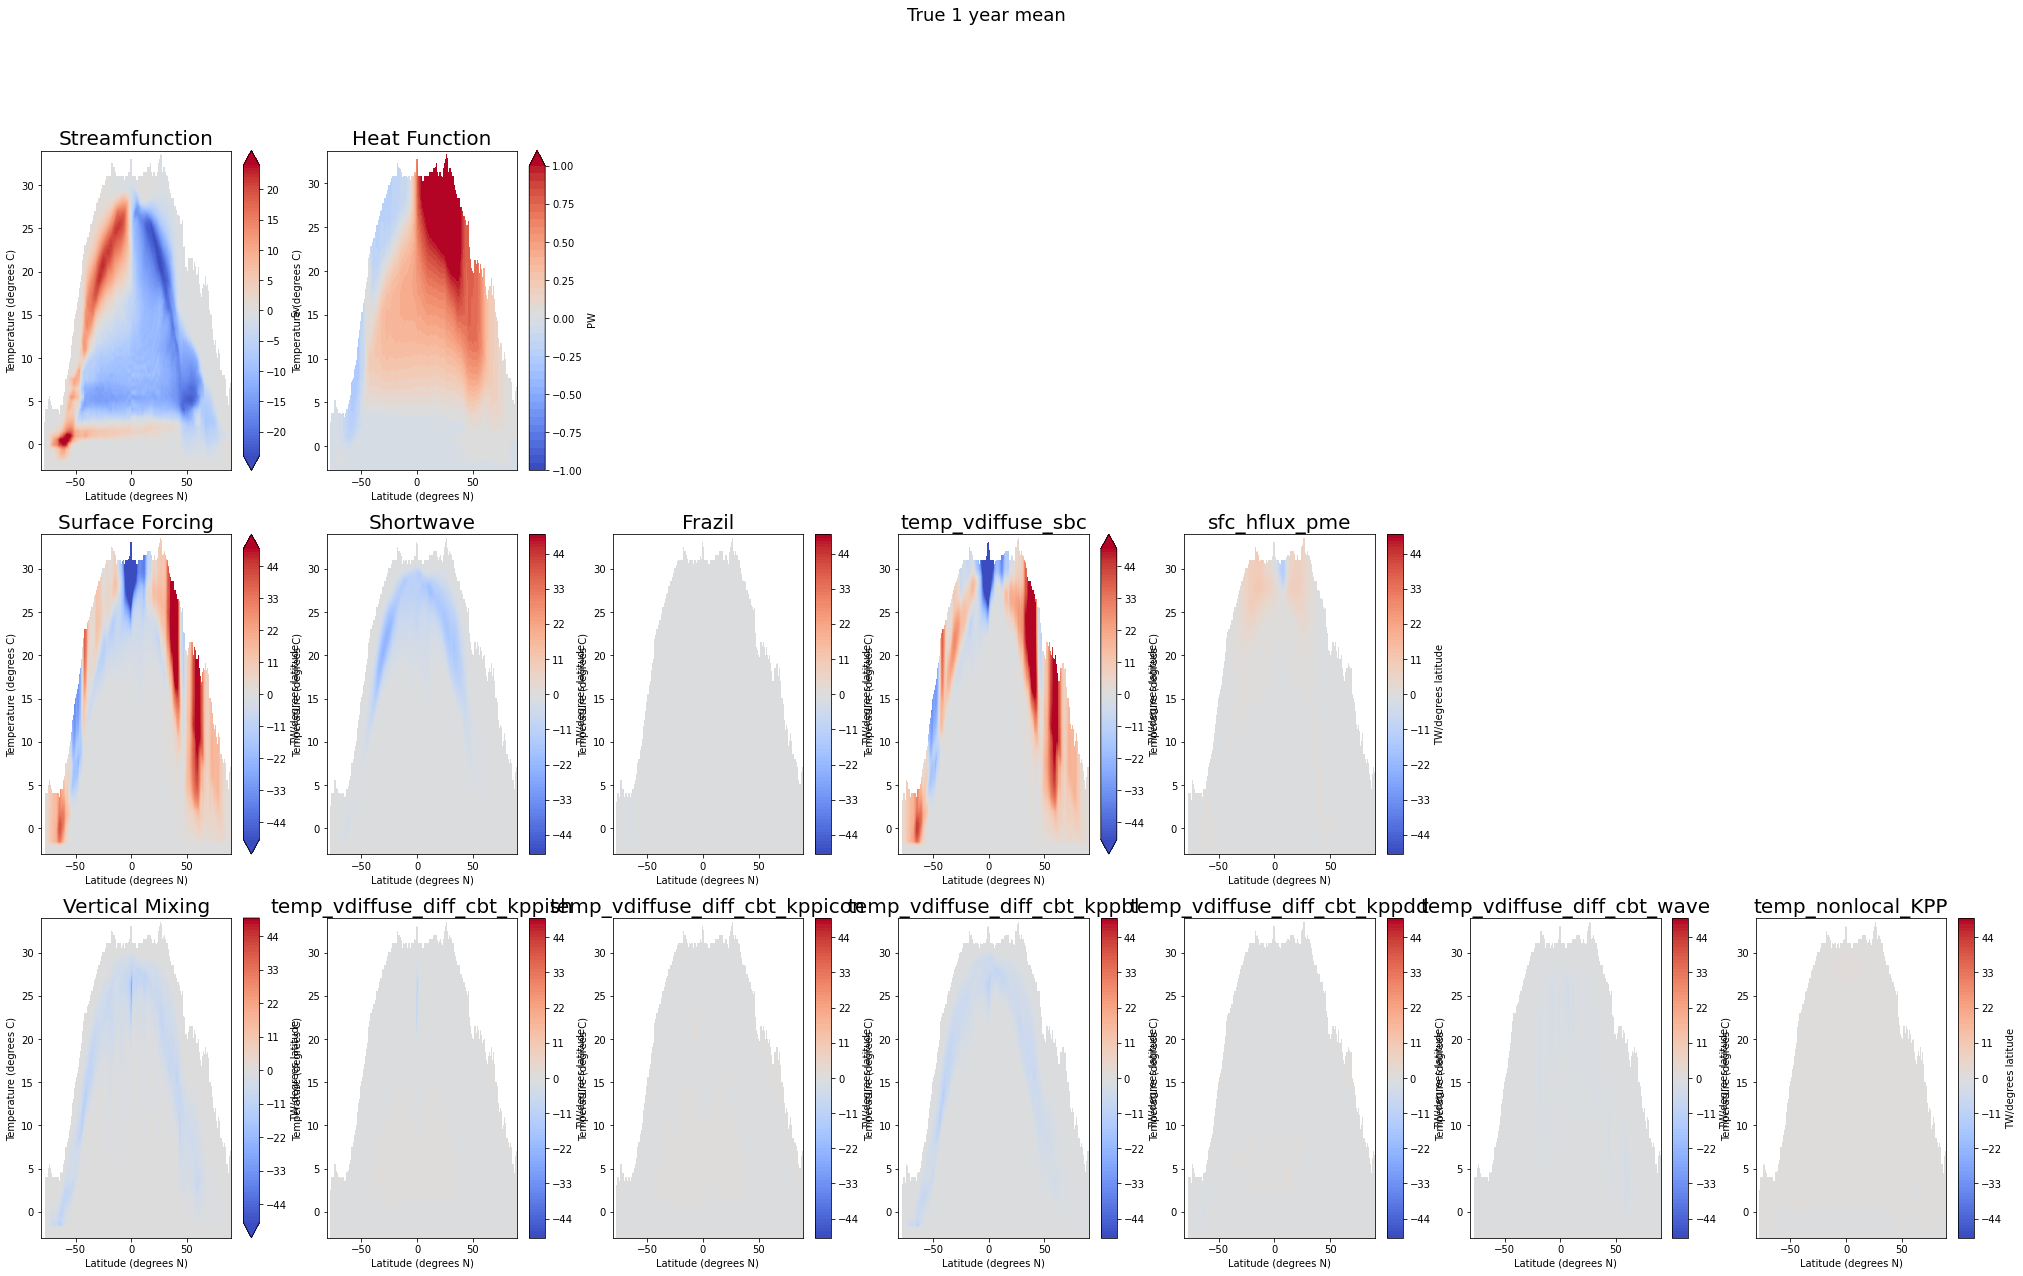

In [21]:
DataSet = True_1year_means
# masking:
maskPsi = 0*True_1year_means.Psi.sum('grid_xt_ocean').where(True_1year_means.Psi.sum('grid_xt_ocean')!=True_1year_means.Psi.sum('grid_xt_ocean').isel(neutralrho_edges=-1))+1.
maskHf = gridwm.interp(maskPsi,'T')
maskSF = gridwm.interp(maskPsi,'y',boundary="fill",fill_value=0.)
maskSF

Psicbar = np.arange(-24.,24.5,0.5)
Hfcbar = np.arange(-1.,1.05,0.05)
SFcbar = np.arange(-50.,51.,1.)
MXcbar = np.arange(-25.,25.,1.)/2
plot_decomp_3d_to_2d(DataSet, Psicbar, Hfcbar, MXcbar, 'True 1 year mean')

### Load 1 year mean (mean_tot)

In [33]:
%%time

Psi_mean_tot.load()
SF_mean_tot.load()
MX_mean_tot.load()

sw_heat_mean_tot.load()
frazil_3d_mean_tot.load()
temp_vdiffuse_sbc_mean_tot.load()
temp_vdiffuse_diff_cbt_kppish_mean_tot.load()
temp_vdiffuse_diff_cbt_kppicon_mean_tot.load()
temp_vdiffuse_diff_cbt_kppbl_mean_tot.load()
temp_vdiffuse_diff_cbt_kppdd_mean_tot.load()
temp_vdiffuse_diff_cbt_wave_mean_tot.load()

CPU times: user 33.8 s, sys: 22.4 s, total: 56.2 s
Wall time: 2min 55s


<xarray.DataArray 'concatenate-f656643f03b9b3eb93dcfd1d3c4ba193' (
                                                                  grid_yt_ocean: 1080,
                                                                  grid_xt_ocean: 1440,
                                                                  neutralrho_edges: 75)>
array([[[-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        ...,
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.]],

       [[-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        ...,
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.]],

       [[-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        ...,
...
        ...,
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.]],

       [[-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        ...,
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.]],

       [[-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        ...,
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.]]])
Coordinates:
  * grid_yt_ocean     (grid_yt_ocean) float64 -81.08 -80.97 ... 89.84 89.95
  * grid_xt_ocean     (grid_xt_ocean) float64 -279.9 -279.6 ... 79.62 79.88
  * neutralrho_edges  (neutralrho_edges) float64 -3.0 -2.5 -2.0 ... 33.5 34.0

In [35]:
ds = xr.Dataset({'Psi': Psi_mean_tot, 'SF': SF_mean_tot, 'MX': MX_mean_tot, 'sw_heat':sw_heat_mean_tot, 'frazil_3d':frazil_3d_mean_tot, 'temp_vdiffuse_sbc':temp_vdiffuse_sbc_mean_tot,'temp_vdiffuse_diff_cbt_kppish':temp_vdiffuse_diff_cbt_kppish_mean_tot,
                'temp_vdiffuse_diff_cbt_kppicon':temp_vdiffuse_diff_cbt_kppicon_mean_tot, 'temp_vdiffuse_diff_cbt_kppbl':temp_vdiffuse_diff_cbt_kppbl_mean_tot,
                'temp_vdiffuse_diff_cbt_kppdd':temp_vdiffuse_diff_cbt_kppdd_mean_tot,'temp_vdiffuse_diff_cbt_wave':temp_vdiffuse_diff_cbt_wave_mean_tot})
ds.to_netcdf('/scratch/e14/cy8964/temp/025deg_096_3d/Mean_1year_means.nc', 
         encoding={'Psi': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'SF': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'MX': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'sw_heat': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'frazil_3d': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_sbc': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_kppish': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_kppicon': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_kppbl': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_kppdd': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_wave': {'shuffle': True, 'zlib': True, 'complevel': 5}})

In [36]:
Mean_1year_means = xr.open_mfdataset('/scratch/e14/cy8964/temp/025deg_096_3d/Mean_1year_means.nc').chunk({'grid_yu_ocean':ych,'grid_yt_ocean':ych, 'grid_xt_ocean':xch})

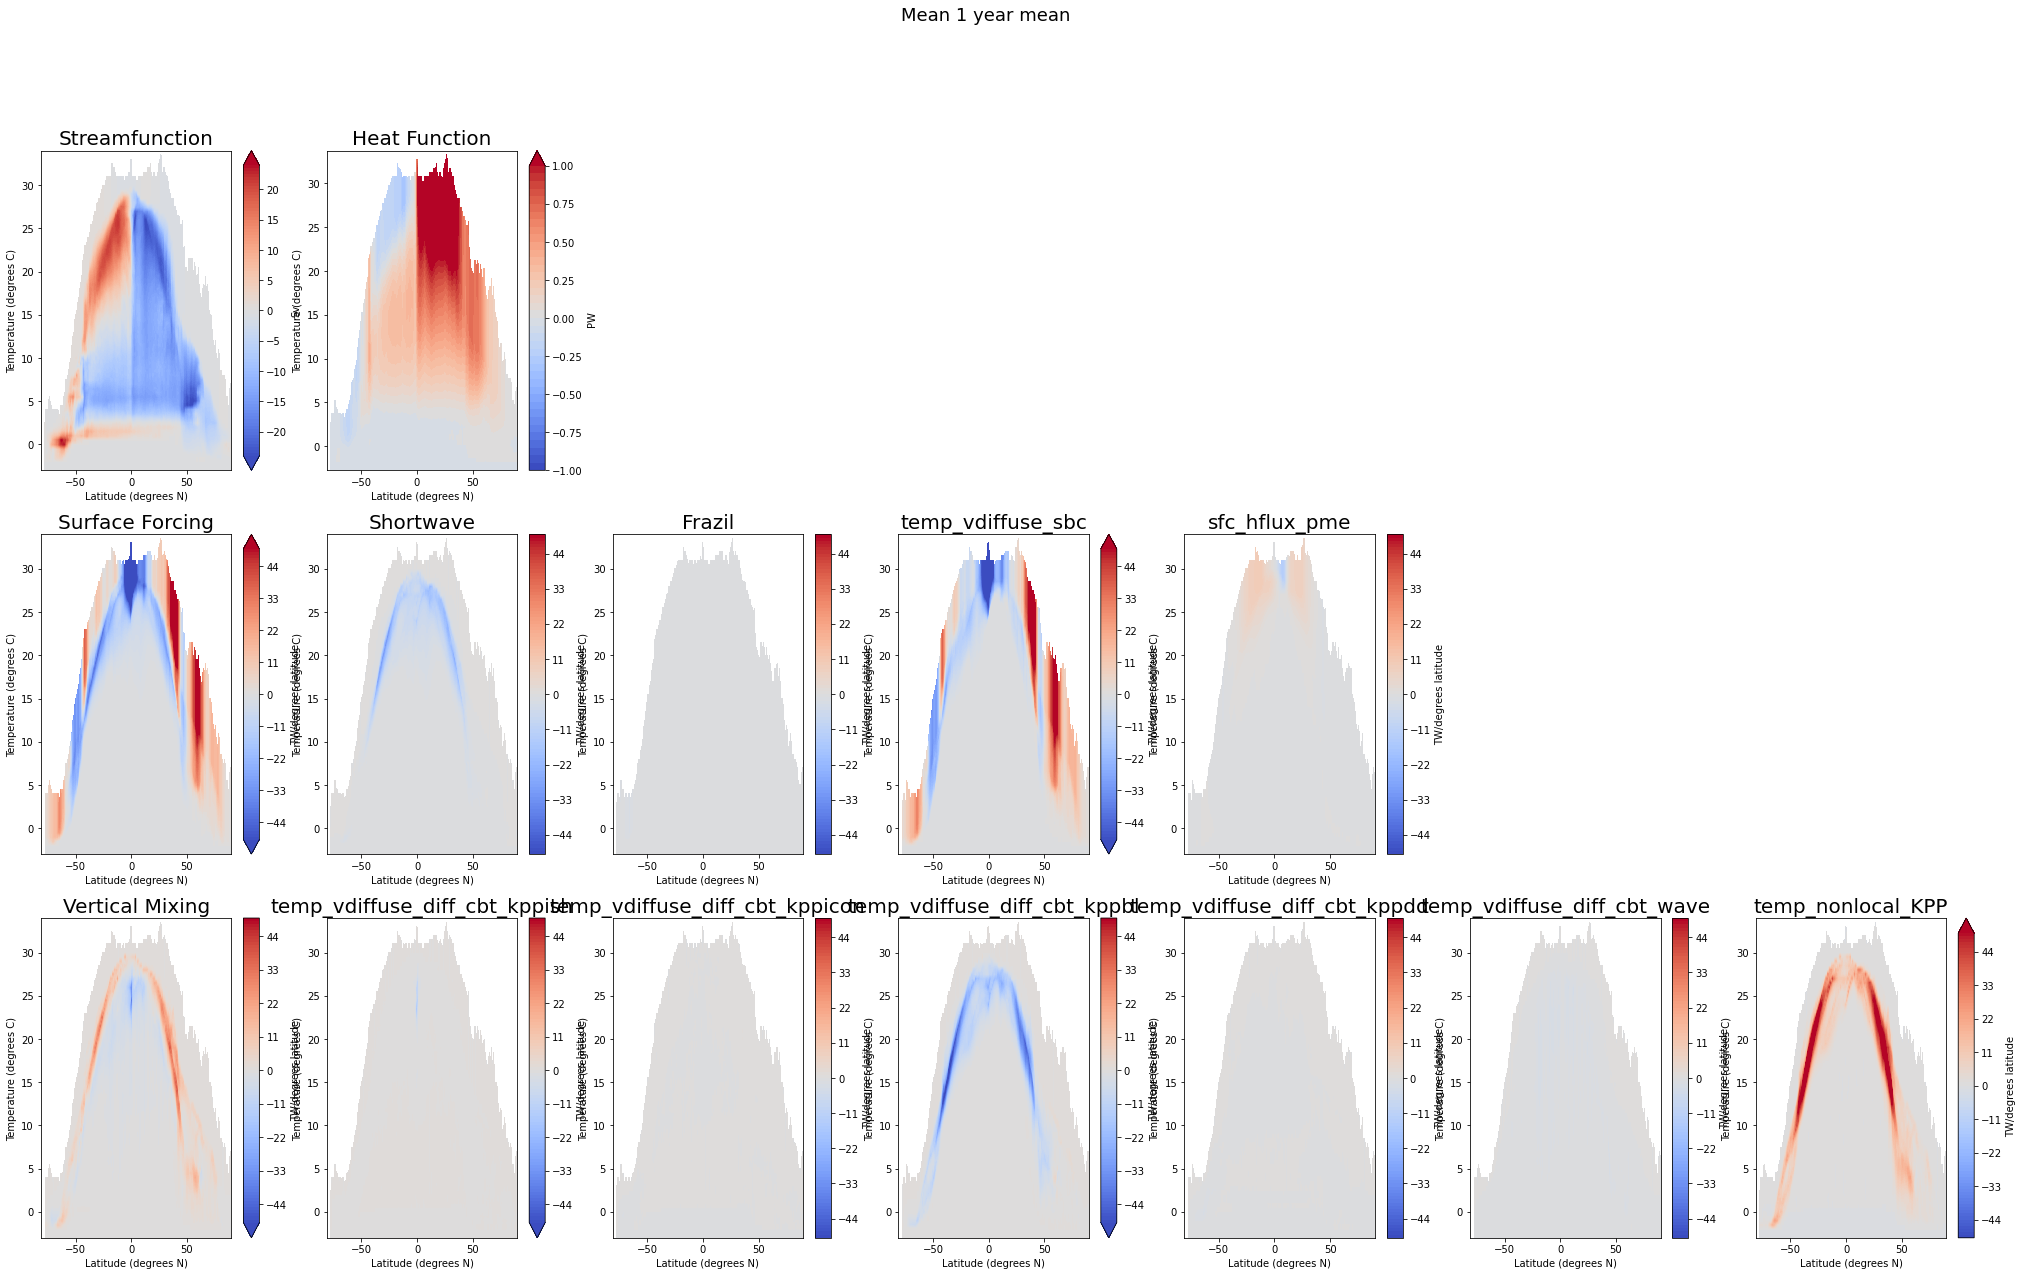

In [37]:
DataSet = Mean_1year_means

Hf = -Cp*rho0*dT*gridwm.cumsum(DataSet.Psi,'T',boundary="fill", fill_value=0)


Psicbar = np.arange(-24.,24.5,0.5)
Hfcbar = np.arange(-1.,1.05,0.05)
SFcbar = np.arange(-50.,51.,1.)
MXcbar = np.arange(-25.,25.,1.)

plot_decomp_3d_to_2d(DataSet, Psicbar, Hfcbar, MXcbar, 'Mean 1 year mean')

### Load 2 month running mean quantities

In [23]:
Psi_mean_2mo = weighted_time_mean_2mo_filter(Psi_mean_2mo)
SF_mean_2mo = weighted_time_mean_2mo_filter(SF_mean_2mo)
MX_mean_2mo = weighted_time_mean_2mo_filter(MX_mean_2mo)

sw_heat_mean_2mo = weighted_time_mean_2mo_filter(sw_heat_mean_2mo)
frazil_3d_mean_2mo = weighted_time_mean_2mo_filter(frazil_3d_mean_2mo)
temp_vdiffuse_sbc_mean_2mo = weighted_time_mean_2mo_filter(temp_vdiffuse_sbc_mean_2mo)

temp_vdiffuse_diff_cbt_kppish_mean_2mo = weighted_time_mean_2mo_filter(temp_vdiffuse_diff_cbt_kppish_mean_2mo)
temp_vdiffuse_diff_cbt_kppicon_mean_2mo = weighted_time_mean_2mo_filter(temp_vdiffuse_diff_cbt_kppicon_mean_2mo)
temp_vdiffuse_diff_cbt_kppbl_mean_2mo = weighted_time_mean_2mo_filter(temp_vdiffuse_diff_cbt_kppbl_mean_2mo)
temp_vdiffuse_diff_cbt_kppdd_mean_2mo = weighted_time_mean_2mo_filter(temp_vdiffuse_diff_cbt_kppdd_mean_2mo)
temp_vdiffuse_diff_cbt_wave_mean_2mo = weighted_time_mean_2mo_filter(temp_vdiffuse_diff_cbt_wave_mean_2mo)

In [24]:
%%time

Psi_mean_2mo.load()
SF_mean_2mo.load()
MX_mean_2mo.load()

sw_heat_mean_2mo.load()
frazil_3d_mean_2mo.load()
temp_vdiffuse_sbc_mean_2mo.load()

temp_vdiffuse_diff_cbt_kppish_mean_2mo.load()
temp_vdiffuse_diff_cbt_kppicon_mean_2mo.load()
temp_vdiffuse_diff_cbt_kppbl_mean_2mo.load()
temp_vdiffuse_diff_cbt_kppdd_mean_2mo.load()
temp_vdiffuse_diff_cbt_wave_mean_2mo.load()

CPU times: user 4min 15s, sys: 29.7 s, total: 4min 45s
Wall time: 6min 56s


<xarray.DataArray (grid_yt_ocean: 1080, grid_xt_ocean: 1440,
                   neutralrho_edges: 75)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
  * grid_yt_ocean     (grid_yt_ocean) float64 -81.08 -80.97 ... 89.84 89.95
  * grid_xt_ocean     (grid_xt_ocean) float64 -279.9 -279.6 ... 79.62 79.88
  * neutralrho_edges  (neutralrho_edges) float64 -3.0 -2.5 -2.0 ... 33.5 34.0

In [25]:
ds = xr.Dataset({'Psi': Psi_mean_2mo, 'SF': SF_mean_2mo, 'MX': MX_mean_2mo, 'sw_heat':sw_heat_mean_2mo, 'frazil_3d':frazil_3d_mean_2mo, 'temp_vdiffuse_sbc':temp_vdiffuse_sbc_mean_2mo,'temp_vdiffuse_diff_cbt_kppish':temp_vdiffuse_diff_cbt_kppish_mean_2mo,
                'temp_vdiffuse_diff_cbt_kppicon':temp_vdiffuse_diff_cbt_kppicon_mean_2mo, 'temp_vdiffuse_diff_cbt_kppbl':temp_vdiffuse_diff_cbt_kppbl_mean_2mo,
                'temp_vdiffuse_diff_cbt_kppdd':temp_vdiffuse_diff_cbt_kppdd_mean_2mo,'temp_vdiffuse_diff_cbt_wave':temp_vdiffuse_diff_cbt_wave_mean_2mo})
ds.to_netcdf('/scratch/e14/cy8964/temp/025deg_096_3d/2mo_mean_1year_means.nc', 
         encoding={'Psi': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'SF': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'MX': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'sw_heat': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'frazil_3d': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_sbc': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_kppish': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_kppicon': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_kppbl': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_kppdd': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_wave': {'shuffle': True, 'zlib': True, 'complevel': 5}})

2022-06-02 12:30:52,603 - distributed.nanny - WARNING - Restarting worker
2022-06-02 12:30:52,809 - distributed.nanny - WARNING - Restarting worker
2022-06-02 12:30:52,813 - distributed.nanny - WARNING - Restarting worker
2022-06-02 12:30:53,021 - distributed.nanny - WARNING - Restarting worker
2022-06-02 12:30:53,032 - distributed.nanny - WARNING - Restarting worker
2022-06-02 12:30:53,136 - distributed.nanny - WARNING - Restarting worker
2022-06-02 12:30:53,361 - distributed.nanny - WARNING - Restarting worker
2022-06-02 12:30:53,364 - distributed.nanny - WARNING - Restarting worker
2022-06-02 12:30:53,572 - distributed.nanny - WARNING - Restarting worker
2022-06-02 12:30:53,576 - distributed.nanny - WARNING - Restarting worker
2022-06-02 12:30:53,669 - distributed.nanny - WARNING - Restarting worker
2022-06-02 12:30:53,847 - distributed.nanny - WARNING - Restarting worker
2022-06-02 12:30:54,084 - distributed.nanny - WARNING - Restarting worker


In [27]:
Twomo_mean_1year_means = xr.open_mfdataset('/scratch/e14/cy8964/temp/025deg_096_3d/2mo_mean_1year_means.nc').chunk({'grid_yu_ocean':ych,'grid_yt_ocean':ych, 'grid_xt_ocean':xch})

2022-05-04 09:43:18,800 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 22.31 GiB -- Worker memory limit: 31.25 GiB
2022-05-04 09:43:18,800 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 22.31 GiB -- Worker memory limit: 31.25 GiB
2022-05-04 09:43:18,890 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 22.31 GiB -- Worker memory limit: 31.25 GiB
2022-05-04 09:43:18,990 - distributed

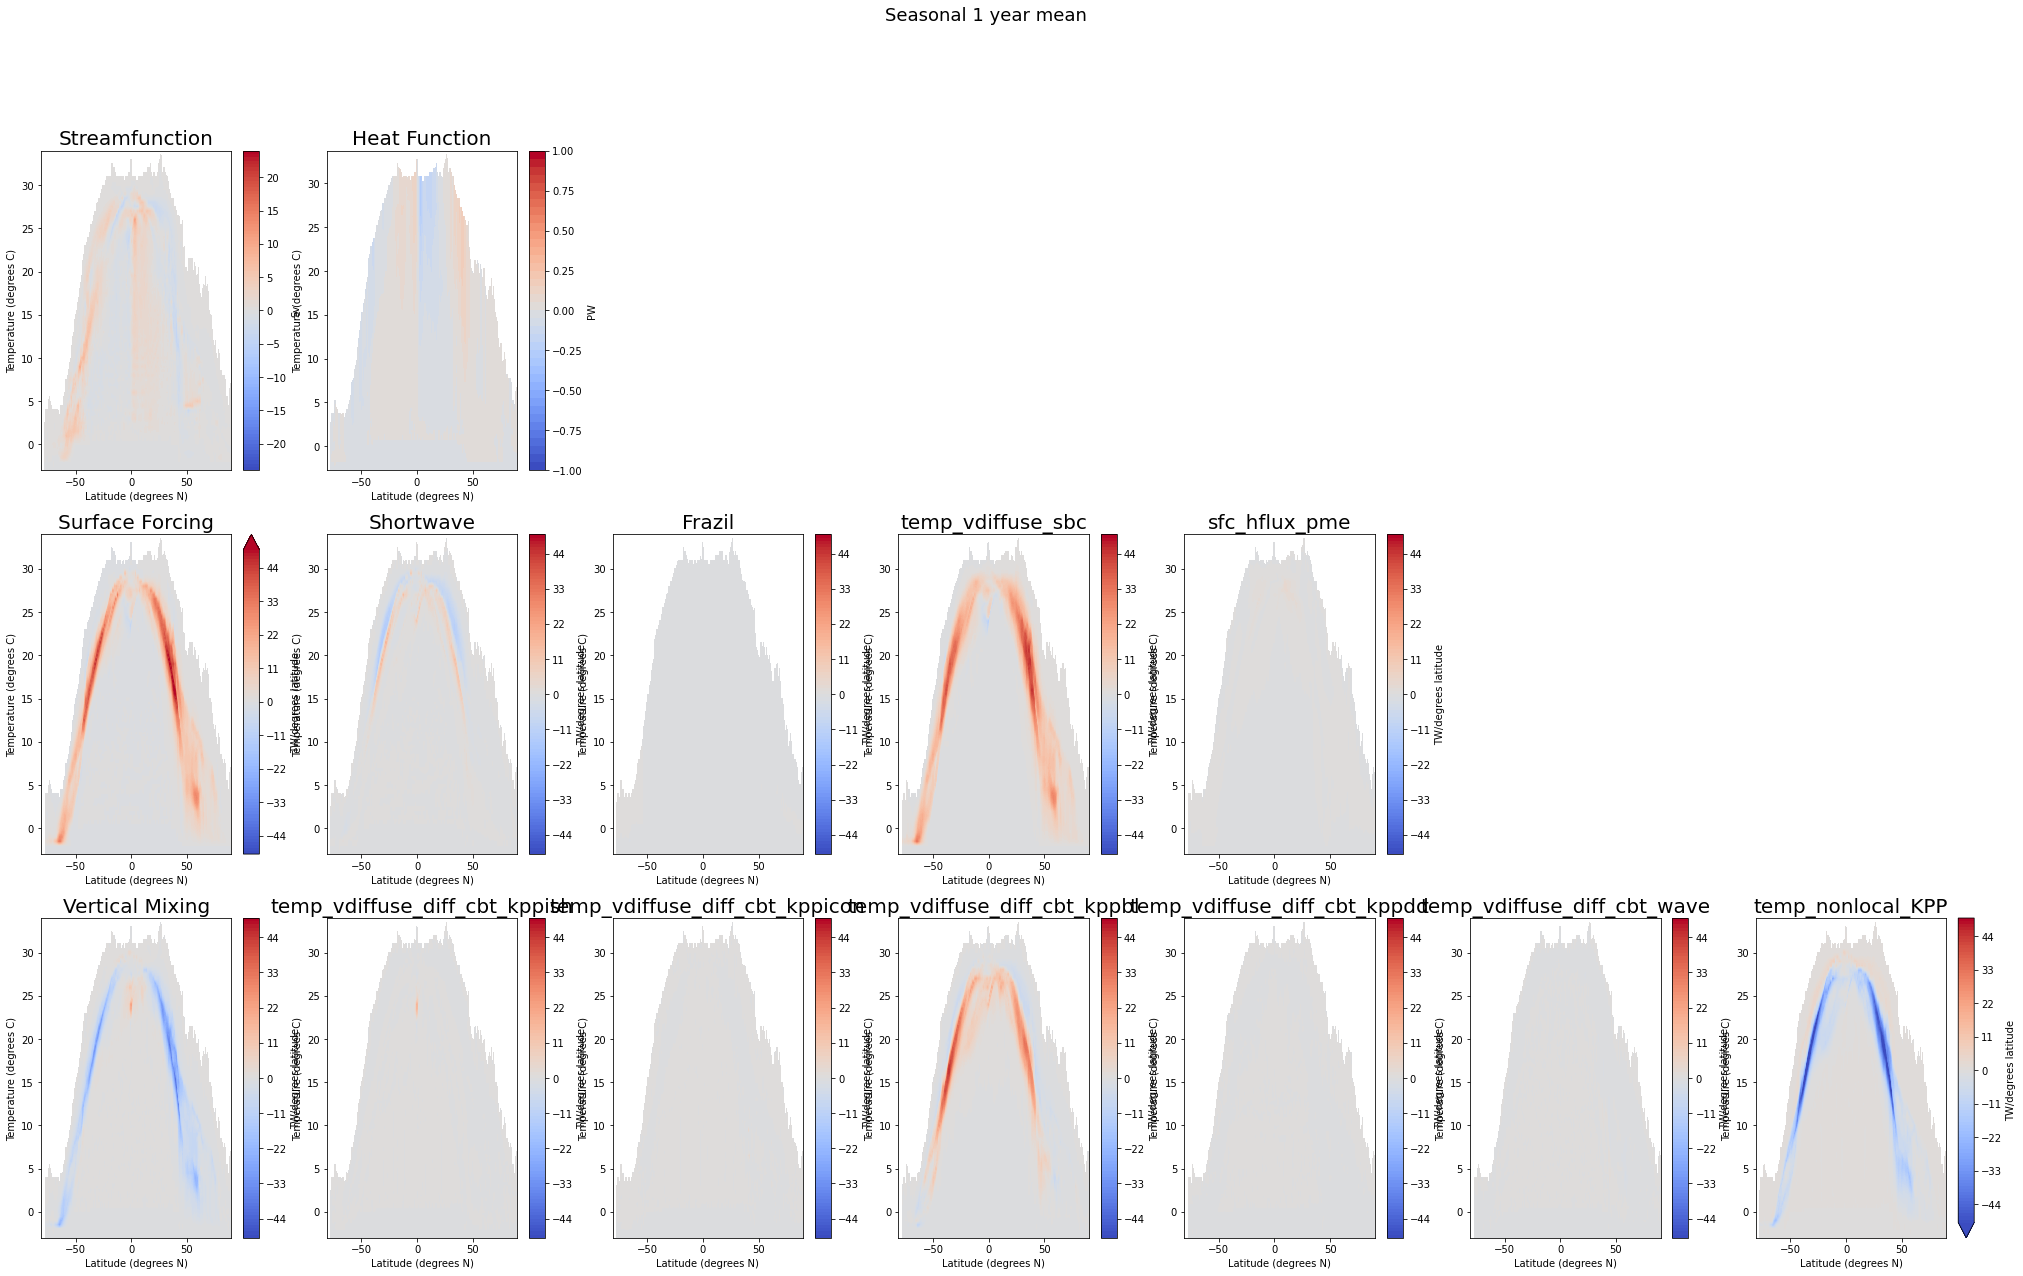

In [43]:
DataSet = Twomo_mean_1year_means - Mean_1year_means

Hf = -Cp*rho0*dT*gridwm.cumsum(DataSet.Psi,'T',boundary="fill", fill_value=0)

Psicbar = np.arange(-24.,24.5,0.5)
Hfcbar = np.arange(-1.,1.05,0.05)
SFcbar = np.arange(-50.,51.,1.)
MXcbar = np.arange(-25.,25.,1.)

cmap = 'coolwarm'

plot_decomp_3d_to_2d(DataSet, Psicbar, Hfcbar, MXcbar, 'Seasonal 1 year mean')

### Load 10 daily quantities

Created script `save_10daily_quantities_xhistogram.py` and ran each of these heat terms individually:


In [32]:
# %%time
# for j in np.array([1]):
#     daily_array = [Psi_mean_10day, SF_10day, MX_10day, sw_heat_10day, frazil_3d_10day, \
#                    temp_vdiffuse_sbc_10day, temp_vdiffuse_diff_cbt_kppish_10day , \
#                    temp_vdiffuse_diff_cbt_kppicon_10day, temp_vdiffuse_diff_cbt_kppbl_10day, \
#                    temp_vdiffuse_diff_cbt_kppdd_10day, temp_vdiffuse_diff_cbt_wave_10day][j]
#     daily_array_name = ['Psi_mean_10day', 'SF_10day', 'MX_10day', 'sw_heat_10day', 'frazil_3d_10day', \
#                         'temp_vdiffuse_sbc_10day','temp_vdiffuse_diff_cbt_kppish_10day', \
#                         'temp_vdiffuse_diff_cbt_kppicon_10day', 'temp_vdiffuse_diff_cbt_kppbl_10day', \
#                         'temp_vdiffuse_diff_cbt_kppdd_10day', 'temp_vdiffuse_diff_cbt_wave_10day'][j]
    
    # k = run_count2
    # if k ==11:
    #     daily_array = daily_array.isel(time = np.arange(k*30,k*30+35))
    # else:
    #     daily_array = daily_array.isel(time = np.arange(k*30,k*30+30))
    # daily_array_timemean = xr.zeros_like(daily_array.isel(time=0))
    # nt = len(daily_array.time.values)
    # for i in range(nt):
    #     print('Doing time step ' + str(i+1) + ' of ' + str(nt))
    #     daily_array_t = daily_array.isel(time=i);
    #     daily_array_t.load()
    #     daily_array_timemean += daily_array_t
    # daily_array_timemean = daily_array_timemean/nt
    # daily_array_timemean.load()
    # ds = xr.Dataset({daily_array_name: daily_array_timemean})
    # ds.to_netcdf('/scratch/e14/cy8964/temp/025deg_096_3d/10daily_mean_1year_means_'+daily_array_name+'_mo'+str(k)+'.nc', 
    #              encoding={daily_array_name: {'shuffle': True, 'zlib': True, 'complevel': 5}})


Doing time step 1 of 365
Doing time step 2 of 365
Doing time step 3 of 365
Doing time step 4 of 365
Doing time step 5 of 365
Doing time step 6 of 365
Doing time step 7 of 365
Doing time step 8 of 365
Doing time step 9 of 365
Doing time step 10 of 365
Doing time step 11 of 365
Doing time step 12 of 365
Doing time step 13 of 365
Doing time step 14 of 365
Doing time step 15 of 365
Doing time step 16 of 365
Doing time step 17 of 365
Doing time step 18 of 365
Doing time step 19 of 365
Doing time step 20 of 365
Doing time step 21 of 365
Doing time step 22 of 365
Doing time step 23 of 365
Doing time step 24 of 365
Doing time step 25 of 365
Doing time step 26 of 365
Doing time step 27 of 365
Doing time step 28 of 365
Doing time step 29 of 365
Doing time step 30 of 365
Doing time step 31 of 365
Doing time step 32 of 365
Doing time step 33 of 365
Doing time step 34 of 365
Doing time step 35 of 365
Doing time step 36 of 365
Doing time step 37 of 365
Doing time step 38 of 365
Doing time step 39 of

2022-04-29 12:06:17,178 - distributed.nanny - WARNING - Restarting worker
2022-04-29 12:06:17,420 - distributed.nanny - WARNING - Restarting worker
2022-04-29 12:06:17,424 - distributed.nanny - WARNING - Restarting worker
2022-04-29 12:06:17,856 - distributed.nanny - WARNING - Restarting worker
2022-04-29 12:06:18,070 - distributed.nanny - WARNING - Restarting worker
2022-04-29 12:06:18,073 - distributed.nanny - WARNING - Restarting worker
2022-04-29 12:06:18,077 - distributed.nanny - WARNING - Restarting worker
2022-04-29 12:06:18,235 - distributed.nanny - WARNING - Restarting worker
2022-04-29 12:06:18,548 - distributed.nanny - WARNING - Restarting worker
2022-04-29 12:06:18,800 - distributed.nanny - WARNING - Restarting worker


Needed to do it by month (30days + 35 for last one) because memory intensive.

Now combine the monthly stuff into a total for each term:

0
1
2
3
4
5
6
7
8
9
10
11


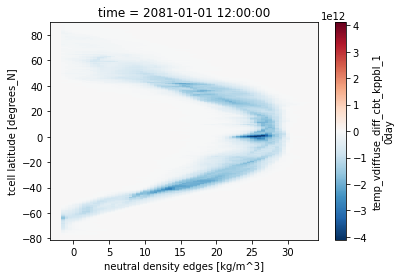

0
1
2
3
4
5
6
7
8
9
10
11


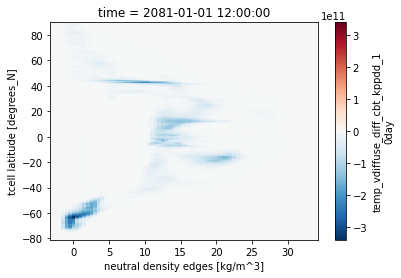

0
1
2
3
4
5
6
7
8
9
10
11


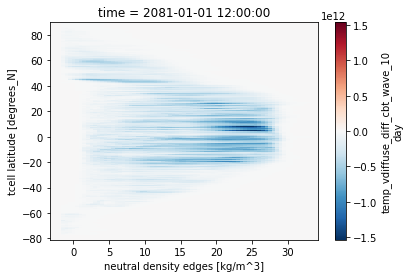

CPU times: user 4min 24s, sys: 59.7 s, total: 5min 23s
Wall time: 5min 8s


In [23]:
%%time
for j in np.arange(8,11):
    daily_array_name = ['Psi_mean_10day', 'SF_10day', 'MX_10day', 'sw_heat_10day', 'frazil_3d_10day', \
                        'temp_vdiffuse_sbc_10day','temp_vdiffuse_diff_cbt_kppish_10day', \
                        'temp_vdiffuse_diff_cbt_kppicon_10day', 'temp_vdiffuse_diff_cbt_kppbl_10day', \
                        'temp_vdiffuse_diff_cbt_kppdd_10day', 'temp_vdiffuse_diff_cbt_wave_10day'][j]
    mo = '0'
    save_dir = '/scratch/e14/cy8964/temp/025deg_096_3d/'
    term1 = xr.open_dataarray(save_dir+'10daily_mean_1year_means_'+daily_array_name+'_mo'+mo+'.nc')#.daily_array_name
    term1  = xr.zeros_like(term1)
    term1  = term1.expand_dims({"mo":np.arange(12)}).copy()
    daylengths = [30,30,30,30,30,30,30,30,30,30,30,35]
    for k in np.arange(12):
        print(k)
        year = str(k)
        term1_k = xr.open_dataarray(save_dir+'10daily_mean_1year_means_'+daily_array_name+'_mo'+str(k)+'.nc')
        #term1_k.sum('grid_xt_ocean').plot()
        #plt.show()#.daily_array_name
        term1[k,:,:,:] = term1_k*daylengths[k]

    term1 = term1.sum('mo')/365
    term1.load()
    term1.sum('grid_xt_ocean').plot()
    plt.show()
    ds = xr.Dataset({daily_array_name: term1})
    ds.to_netcdf('/scratch/e14/cy8964/temp/025deg_096_3d/10daily_mean_1year_means_'+daily_array_name+'.nc', 
                 encoding={daily_array_name: {'shuffle': True, 'zlib': True, 'complevel': 5}})

    

In [24]:
# load from PBS script output
Psi_mean_10day = xr.open_dataset('/scratch/e14/cy8964/temp/025deg_096_3d/10daily_mean_1year_means_Psi_mean_10day.nc').Psi_mean_10day
SF_10day = xr.open_dataset('/scratch/e14/cy8964/temp/025deg_096_3d/10daily_mean_1year_means_SF_10day.nc').SF_10day
MX_10day = xr.open_dataset('/scratch/e14/cy8964/temp/025deg_096_3d/10daily_mean_1year_means_MX_10day.nc').MX_10day
sw_heat_10day    = xr.open_dataset('/scratch/e14/cy8964/temp/025deg_096_3d/10daily_mean_1year_means_sw_heat_10day.nc').sw_heat_10day
frazil_3d_10day    = xr.open_dataset('/scratch/e14/cy8964/temp/025deg_096_3d/10daily_mean_1year_means_frazil_3d_10day.nc').frazil_3d_10day
temp_vdiffuse_sbc_10day    = xr.open_dataset('/scratch/e14/cy8964/temp/025deg_096_3d/10daily_mean_1year_means_temp_vdiffuse_sbc_10day.nc').temp_vdiffuse_sbc_10day
temp_vdiffuse_diff_cbt_kppish_10day = xr.open_dataset('/scratch/e14/cy8964/temp/025deg_096_3d/10daily_mean_1year_means_temp_vdiffuse_diff_cbt_kppish_10day.nc').temp_vdiffuse_diff_cbt_kppish_10day 
temp_vdiffuse_diff_cbt_kppicon_10day= xr.open_dataset('/scratch/e14/cy8964/temp/025deg_096_3d/10daily_mean_1year_means_temp_vdiffuse_diff_cbt_kppicon_10day.nc').temp_vdiffuse_diff_cbt_kppicon_10day
temp_vdiffuse_diff_cbt_kppbl_10day= xr.open_dataset('/scratch/e14/cy8964/temp/025deg_096_3d/10daily_mean_1year_means_temp_vdiffuse_diff_cbt_kppbl_10day.nc').temp_vdiffuse_diff_cbt_kppbl_10day
temp_vdiffuse_diff_cbt_kppdd_10day= xr.open_dataset('/scratch/e14/cy8964/temp/025deg_096_3d/10daily_mean_1year_means_temp_vdiffuse_diff_cbt_kppdd_10day.nc').temp_vdiffuse_diff_cbt_kppdd_10day
temp_vdiffuse_diff_cbt_wave_10day= xr.open_dataset('/scratch/e14/cy8964/temp/025deg_096_3d/10daily_mean_1year_means_temp_vdiffuse_diff_cbt_wave_10day.nc').temp_vdiffuse_diff_cbt_wave_10day


In [25]:
# save to array
ds = xr.Dataset({'Psi': Psi_mean_10day, 'SF': SF_10day, 'MX': MX_10day, 'sw_heat':sw_heat_10day,'frazil_3d':frazil_3d_10day, 'temp_vdiffuse_sbc':temp_vdiffuse_sbc_10day, 'temp_vdiffuse_diff_cbt_kppish':temp_vdiffuse_diff_cbt_kppish_10day,
                'temp_vdiffuse_diff_cbt_kppicon':temp_vdiffuse_diff_cbt_kppicon_10day, 'temp_vdiffuse_diff_cbt_kppbl':temp_vdiffuse_diff_cbt_kppbl_10day,
                'temp_vdiffuse_diff_cbt_kppdd':temp_vdiffuse_diff_cbt_kppdd_10day,'temp_vdiffuse_diff_cbt_wave':temp_vdiffuse_diff_cbt_wave_10day})
ds.to_netcdf('/scratch/e14/cy8964/temp/025deg_096_3d/10day_mean_1year_means.nc', 
         encoding={'Psi': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'MX': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'sw_heat': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'frazil_3d': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_sbc': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'SF': {'shuffle': True, 'zlib': True, 'complevel': 5},                   
                  'temp_vdiffuse_diff_cbt_kppish': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_kppicon': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_kppbl': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_kppdd': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_wave': {'shuffle': True, 'zlib': True, 'complevel': 5}})

In [26]:
Tenday_mean_1year_means = xr.open_mfdataset('/scratch/e14/cy8964/temp/025deg_096_3d/10day_mean_1year_means.nc').chunk({'grid_yu_ocean':ych,'grid_yt_ocean':ych, 'grid_xt_ocean':xch})

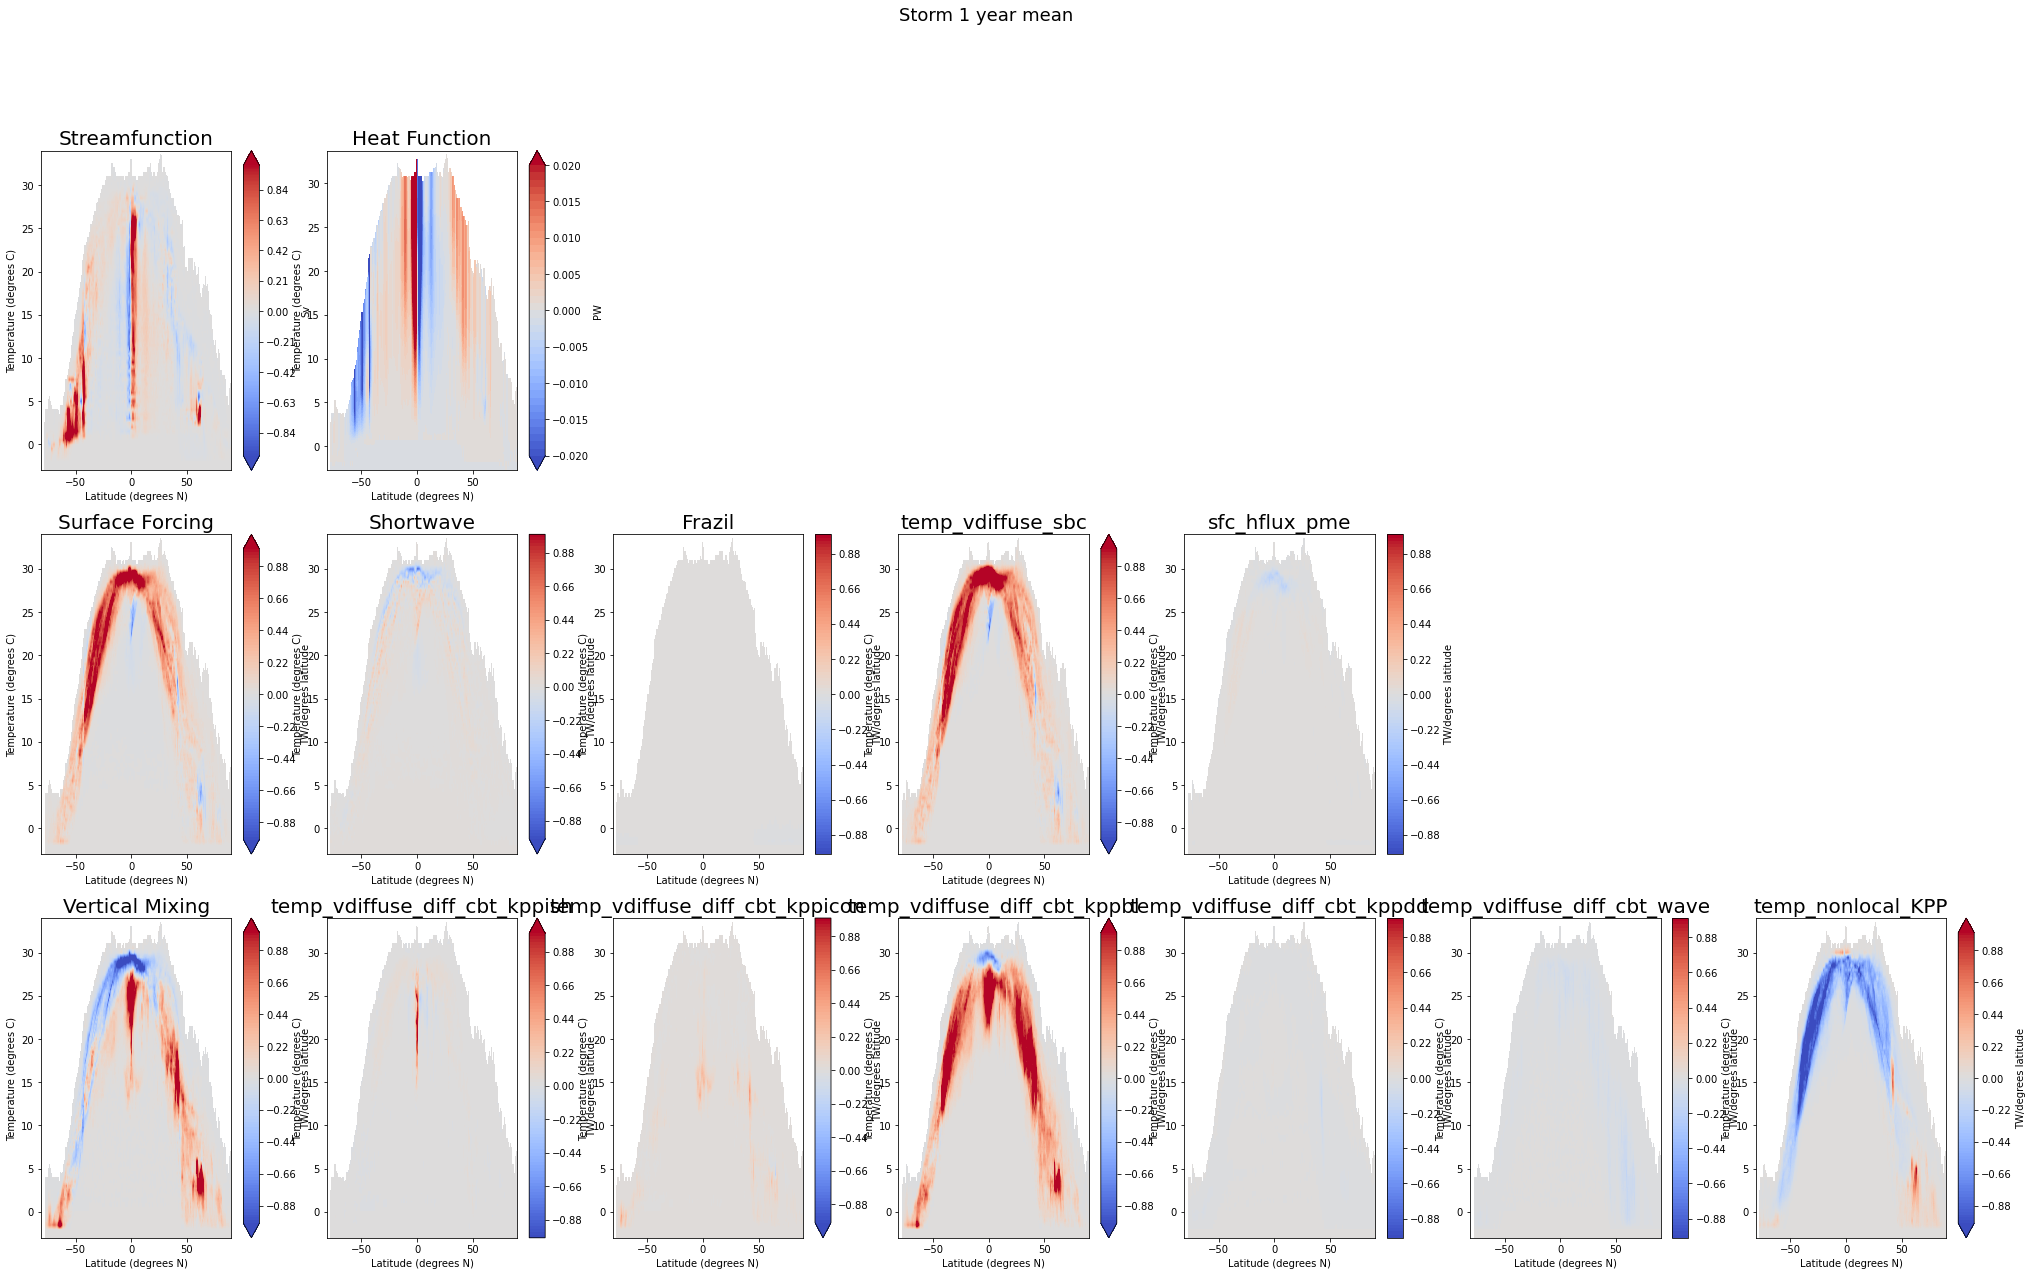

In [28]:
DataSet = Oneday_mean_1year_means - Tenday_mean_1year_means
Hf = -Cp*rho0*dT*gridwm.cumsum(DataSet.Psi,'T',boundary="fill", fill_value=0)

Psicbar = np.arange(-5.,5.1,0.05)/5
Hfcbar = np.arange(-0.1,0.105,0.005)/5
SFcbar = np.arange(-5.,5.1,0.1)/5
MXcbar = np.arange(-2.5,2.51,0.1)/5

plot_decomp_3d_to_2d(DataSet, Psicbar, Hfcbar, MXcbar, 'Storm 1 year mean')

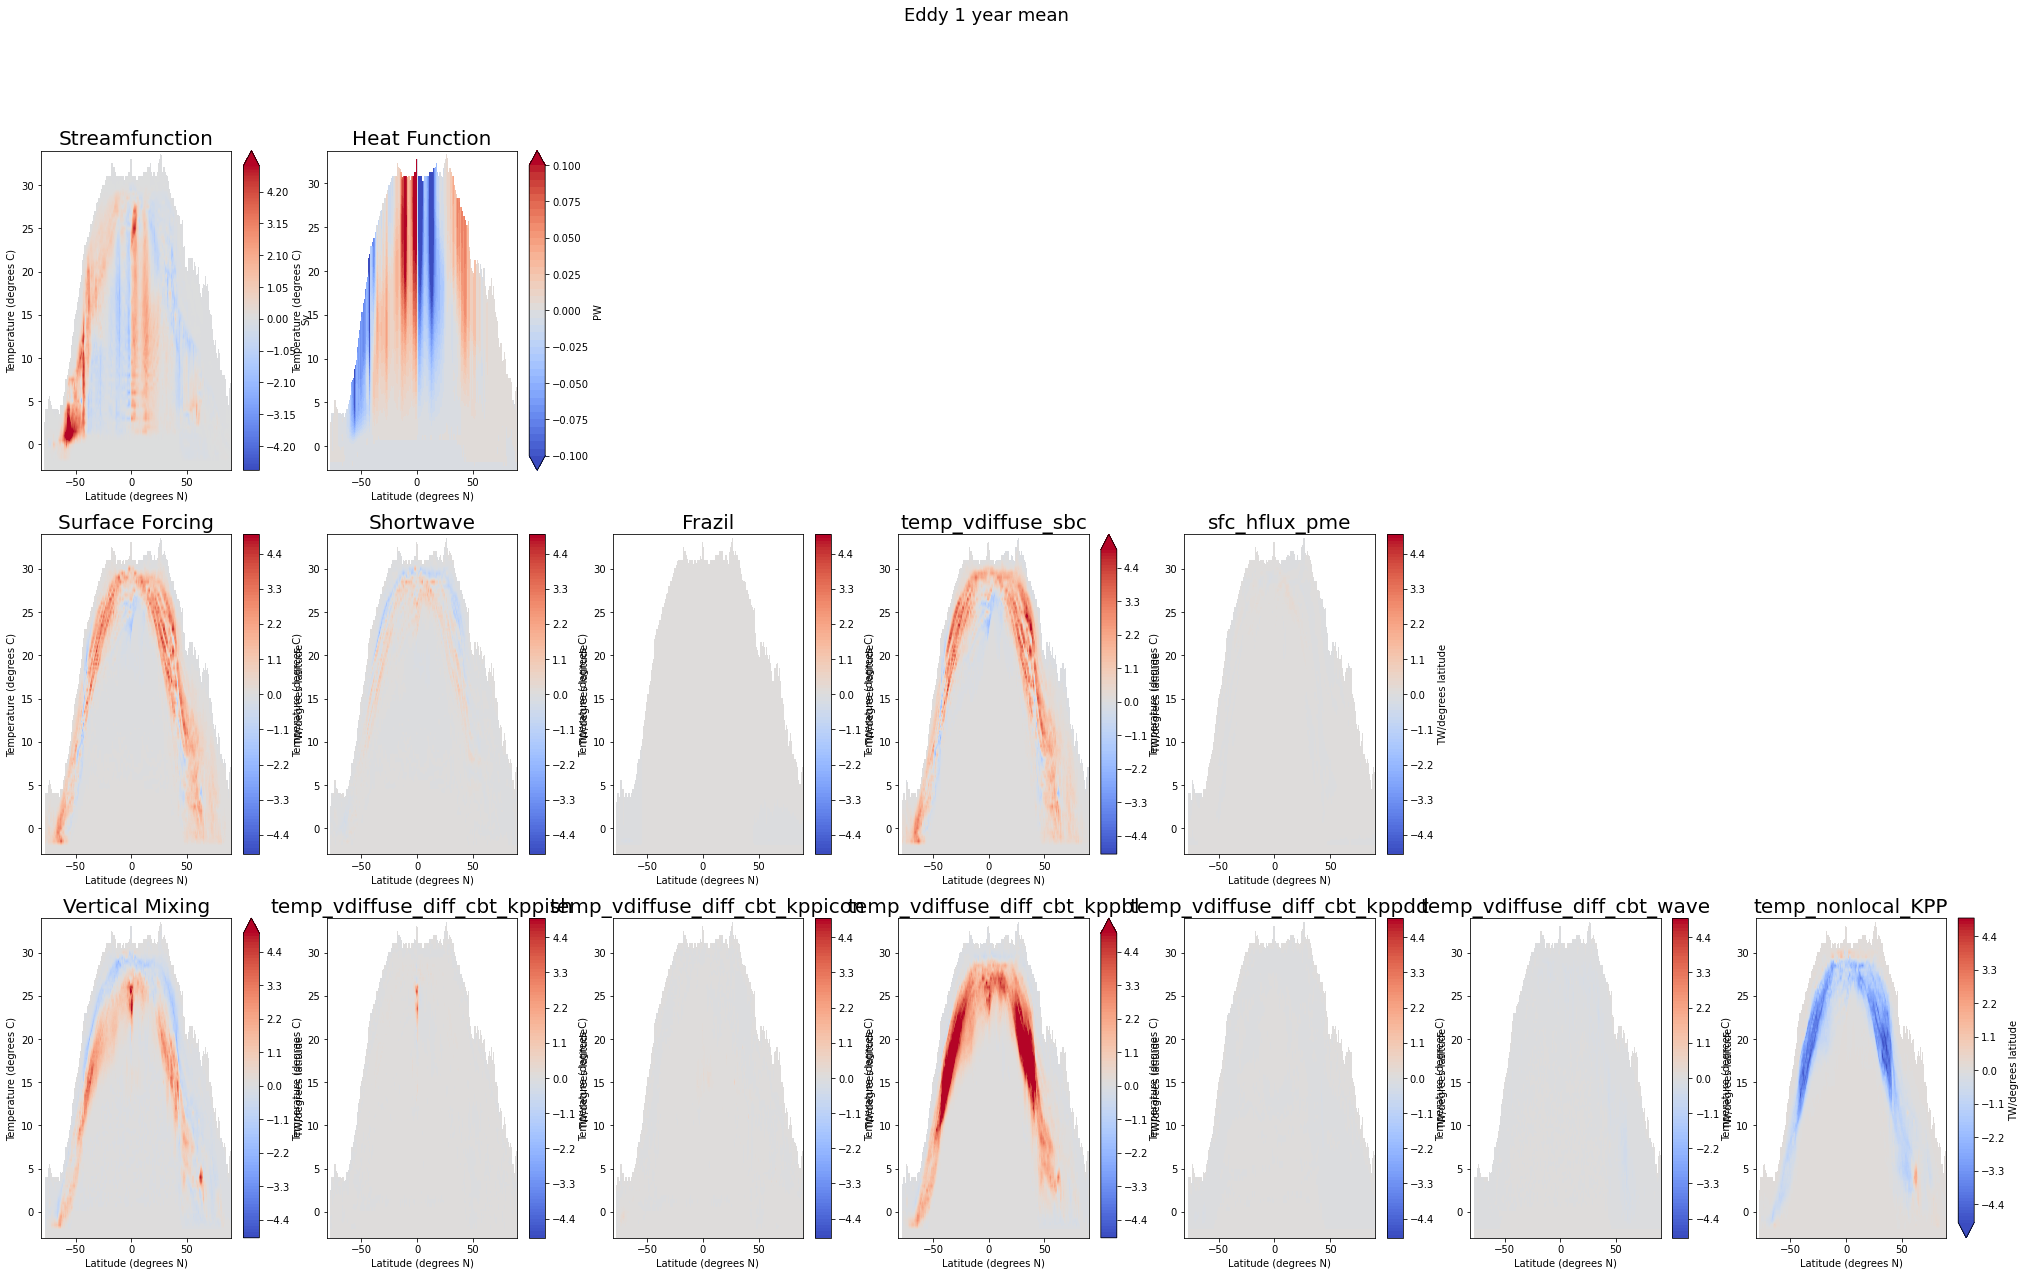

2022-05-05 17:12:06,997 - distributed.nanny - WARNING - Restarting worker
2022-05-05 17:12:07,121 - distributed.nanny - WARNING - Restarting worker
2022-05-05 17:12:07,125 - distributed.nanny - WARNING - Restarting worker
2022-05-05 17:12:07,243 - distributed.nanny - WARNING - Restarting worker
2022-05-05 17:12:07,248 - distributed.nanny - WARNING - Restarting worker
2022-05-05 17:12:07,373 - distributed.nanny - WARNING - Restarting worker
2022-05-05 17:12:07,375 - distributed.nanny - WARNING - Restarting worker
2022-05-05 17:12:07,378 - distributed.nanny - WARNING - Restarting worker
2022-05-05 17:12:07,470 - distributed.nanny - WARNING - Restarting worker
2022-05-05 17:12:07,666 - distributed.nanny - WARNING - Restarting worker
2022-05-05 17:12:07,669 - distributed.nanny - WARNING - Restarting worker
2022-05-05 17:12:07,716 - distributed.nanny - WARNING - Restarting worker
2022-05-05 17:12:07,729 - distributed.nanny - WARNING - Restarting worker
2022-05-05 17:12:07,779 - distributed.

In [29]:

DataSet = Tenday_mean_1year_means - Twomo_mean_1year_means
Hf = -Cp*rho0*dT*gridwm.cumsum(DataSet.Psi,'T',boundary="fill", fill_value=0)

Psicbar = np.arange(-5.,5.1,0.05)
Hfcbar = np.arange(-0.1,0.105,0.005)
SFcbar = np.arange(-5.,5.1,0.1)
MXcbar = np.arange(-2.5,2.51,0.1)

plot_decomp_3d_to_2d(DataSet, Psicbar, Hfcbar, MXcbar, 'Eddy 1 year mean')

### Load 1 daily quantities

PBS python script `save_1daily_quantities_xhistogram.py`



In [ ]:
# %%time
#     j = run_count
#     if j ==11:
#         SF_1day_i = SF_1day.isel(time = np.arange(j*30,j*30+35))
#         print(SF_1day_i.time)
#     else:
#         SF_1day_i = SF_1day.isel(time = np.arange(j*30,j*30+30))
#         print(SF_1day_i.time)
#     SF_1day_timemean_i = xr.zeros_like(SF_1day.isel(time=0))
#     nt = len(SF_1day_i.time)
#     for i in range(nt):
#         print('Doing time step ' + str(i+1) + ' of ' + str(nt))
#         SF_1day_t = SF_1day_i.isel(time=i);
#         SF_1day_t.load()
#         SF_1day_timemean_i += SF_1day_t
#     SF_1day_timemean_i = SF_1day_timemean_i/nt
#     SF_1day_i = SF_1day_timemean_i

#     ds = xr.Dataset({'SF_1day_i': SF_1day_i})
#     ds.to_netcdf('/scratch/e14/cy8964/temp/3D_decomp/SF_1day_i_mo'+str(j)+'.nc', 
#              encoding={'SF_1day_i': {'shuffle': True, 'zlib': True, 'complevel': 5}})





0
1
2
3
4
5
6
7
8
9
10
11


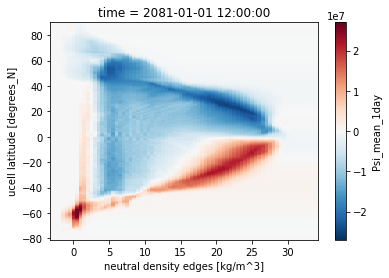

0
1
2
3
4
5
6
7
8
9
10
11


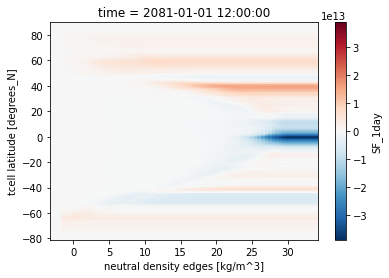

0
1
2
3
4
5
6
7
8
9
10
11


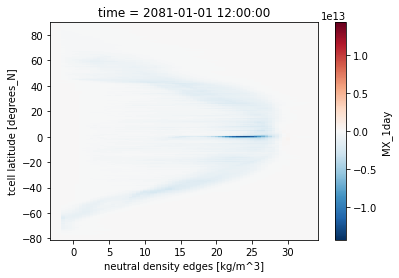

0
1
2
3
4
5
6
7
8
9
10
11


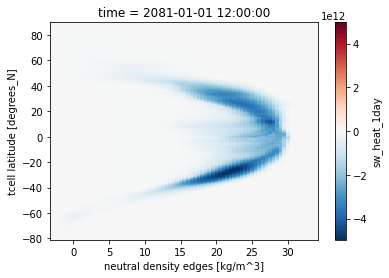

0
1
2
3
4
5
6
7
8
9
10
11


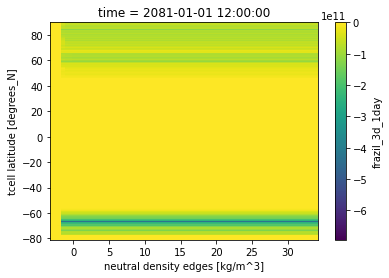

0
1
2
3
4
5
6
7
8
9
10
11


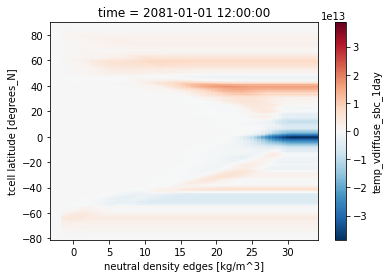

0
1
2
3
4
5
6
7
8
9
10
11


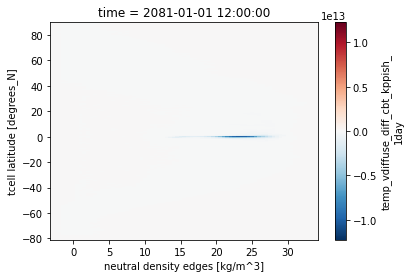

0
1
2
3
4
5
6
7
8
9
10
11


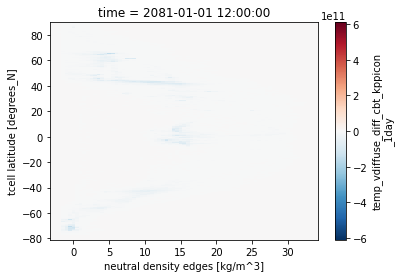

0
1
2
3
4
5
6
7
8
9
10
11


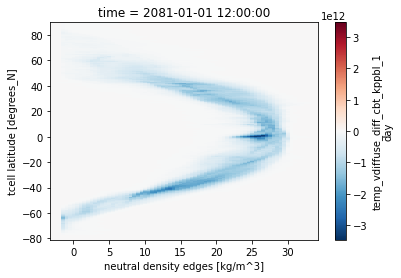

0
1
2
3
4
5
6
7
8
9
10
11


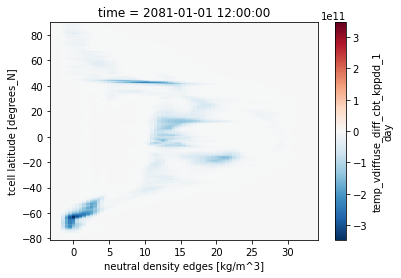

0
1
2
3
4
5
6
7
8
9
10
11


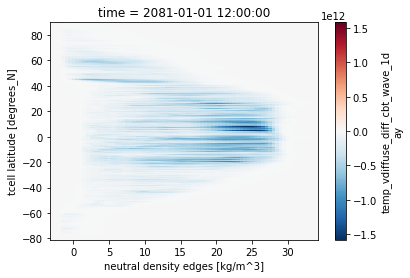

CPU times: user 14min 7s, sys: 2min 31s, total: 16min 38s
Wall time: 16min 5s


2022-05-05 13:48:06,536 - distributed.nanny - WARNING - Restarting worker
2022-05-05 13:48:06,540 - distributed.nanny - WARNING - Restarting worker
2022-05-05 13:48:06,580 - distributed.nanny - WARNING - Restarting worker
2022-05-05 13:48:06,628 - distributed.nanny - WARNING - Restarting worker
2022-05-05 13:48:06,637 - distributed.nanny - WARNING - Restarting worker
2022-05-05 13:48:06,674 - distributed.nanny - WARNING - Restarting worker
2022-05-05 13:48:06,744 - distributed.nanny - WARNING - Restarting worker
2022-05-05 13:48:06,796 - distributed.nanny - WARNING - Restarting worker
2022-05-05 13:48:06,915 - distributed.nanny - WARNING - Restarting worker
2022-05-05 13:48:06,917 - distributed.nanny - WARNING - Restarting worker
2022-05-05 13:48:06,952 - distributed.nanny - WARNING - Restarting worker
2022-05-05 13:48:06,959 - distributed.nanny - WARNING - Restarting worker
2022-05-05 13:48:07,027 - distributed.nanny - WARNING - Restarting worker
2022-05-05 13:48:07,066 - distributed.

In [10]:
%%time
for j in np.arange(11):
    daily_array_name = ['Psi_mean_1day', 'SF_1day', 'MX_1day', 'sw_heat_1day', 'frazil_3d_1day', \
                        'temp_vdiffuse_sbc_1day','temp_vdiffuse_diff_cbt_kppish_1day', \
                        'temp_vdiffuse_diff_cbt_kppicon_1day', 'temp_vdiffuse_diff_cbt_kppbl_1day', \
                        'temp_vdiffuse_diff_cbt_kppdd_1day', 'temp_vdiffuse_diff_cbt_wave_1day'][j]
    mo = '0'
    save_dir = '/scratch/e14/cy8964/temp/025deg_096_3d/'
    term1 = xr.open_dataarray(save_dir+'1daily_mean_1year_means_'+daily_array_name+'_mo'+mo+'.nc')#.daily_array_name
    term1  = xr.zeros_like(term1)
    term1  = term1.expand_dims({"mo":np.arange(12)}).copy()
    daylengths = [30,30,30,30,30,30,30,30,30,30,30,35]
    for k in np.arange(12):
        print(k)
        year = str(k)
        term1_k = xr.open_dataarray(save_dir+'1daily_mean_1year_means_'+daily_array_name+'_mo'+str(k)+'.nc')
        term1[k,:,:,:] = term1_k*daylengths[k]

    term1 = term1.sum('mo')/365
    term1.load()
    term1.sum('grid_xt_ocean').plot()
    plt.show()
    ds = xr.Dataset({daily_array_name: term1})
    ds.to_netcdf('/scratch/e14/cy8964/temp/025deg_096_3d/1daily_mean_1year_means_'+daily_array_name+'.nc', 
                 encoding={daily_array_name: {'shuffle': True, 'zlib': True, 'complevel': 5}})

    

In [15]:
# load from PBS script output
Psi_mean_1day = xr.open_dataset('/scratch/e14/cy8964/temp/025deg_096_3d/1daily_mean_1year_means_Psi_mean_1day.nc').Psi_mean_1day
SF_1day = xr.open_dataset('/scratch/e14/cy8964/temp/025deg_096_3d/1daily_mean_1year_means_SF_1day.nc').SF_1day
MX_1day = xr.open_dataset('/scratch/e14/cy8964/temp/025deg_096_3d/1daily_mean_1year_means_MX_1day.nc').MX_1day
sw_heat_1day    = xr.open_dataset('/scratch/e14/cy8964/temp/025deg_096_3d/1daily_mean_1year_means_sw_heat_1day.nc').sw_heat_1day
frazil_3d_1day    = xr.open_dataset('/scratch/e14/cy8964/temp/025deg_096_3d/1daily_mean_1year_means_frazil_3d_1day.nc').frazil_3d_1day
temp_vdiffuse_sbc_1day    = xr.open_dataset('/scratch/e14/cy8964/temp/025deg_096_3d/1daily_mean_1year_means_temp_vdiffuse_sbc_1day.nc').temp_vdiffuse_sbc_1day
temp_vdiffuse_diff_cbt_kppish_1day = xr.open_dataset('/scratch/e14/cy8964/temp/025deg_096_3d/1daily_mean_1year_means_temp_vdiffuse_diff_cbt_kppish_1day.nc').temp_vdiffuse_diff_cbt_kppish_1day 
temp_vdiffuse_diff_cbt_kppicon_1day= xr.open_dataset('/scratch/e14/cy8964/temp/025deg_096_3d/1daily_mean_1year_means_temp_vdiffuse_diff_cbt_kppicon_1day.nc').temp_vdiffuse_diff_cbt_kppicon_1day
temp_vdiffuse_diff_cbt_kppbl_1day= xr.open_dataset('/scratch/e14/cy8964/temp/025deg_096_3d/1daily_mean_1year_means_temp_vdiffuse_diff_cbt_kppbl_1day.nc').temp_vdiffuse_diff_cbt_kppbl_1day
temp_vdiffuse_diff_cbt_kppdd_1day= xr.open_dataset('/scratch/e14/cy8964/temp/025deg_096_3d/1daily_mean_1year_means_temp_vdiffuse_diff_cbt_kppdd_1day.nc').temp_vdiffuse_diff_cbt_kppdd_1day
temp_vdiffuse_diff_cbt_wave_1day= xr.open_dataset('/scratch/e14/cy8964/temp/025deg_096_3d/1daily_mean_1year_means_temp_vdiffuse_diff_cbt_wave_1day.nc').temp_vdiffuse_diff_cbt_wave_1day


In [16]:
# save to array
ds = xr.Dataset({'Psi': Psi_mean_1day, 'SF': SF_1day, 'MX': MX_1day, 'sw_heat':sw_heat_1day, 'frazil_3d':frazil_3d_1day, 'temp_vdiffuse_sbc':temp_vdiffuse_sbc_1day,'temp_vdiffuse_diff_cbt_kppish':temp_vdiffuse_diff_cbt_kppish_1day,
                'temp_vdiffuse_diff_cbt_kppicon':temp_vdiffuse_diff_cbt_kppicon_1day, 'temp_vdiffuse_diff_cbt_kppbl':temp_vdiffuse_diff_cbt_kppbl_1day,
                'temp_vdiffuse_diff_cbt_kppdd':temp_vdiffuse_diff_cbt_kppdd_1day,'temp_vdiffuse_diff_cbt_wave':temp_vdiffuse_diff_cbt_wave_1day})
ds.to_netcdf('/scratch/e14/cy8964/temp/025deg_096_3d/1day_mean_1year_means.nc', 
         encoding={'Psi': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'SF': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'MX': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'sw_heat': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'frazil_3d': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_sbc': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_kppish': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_kppicon': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_kppbl': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_kppdd': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_wave': {'shuffle': True, 'zlib': True, 'complevel': 5}})

In [17]:
Oneday_mean_1year_means = xr.open_mfdataset('/scratch/e14/cy8964/temp/025deg_096_3d/1day_mean_1year_means.nc').chunk({'grid_yu_ocean':ych,'grid_yt_ocean':ych})

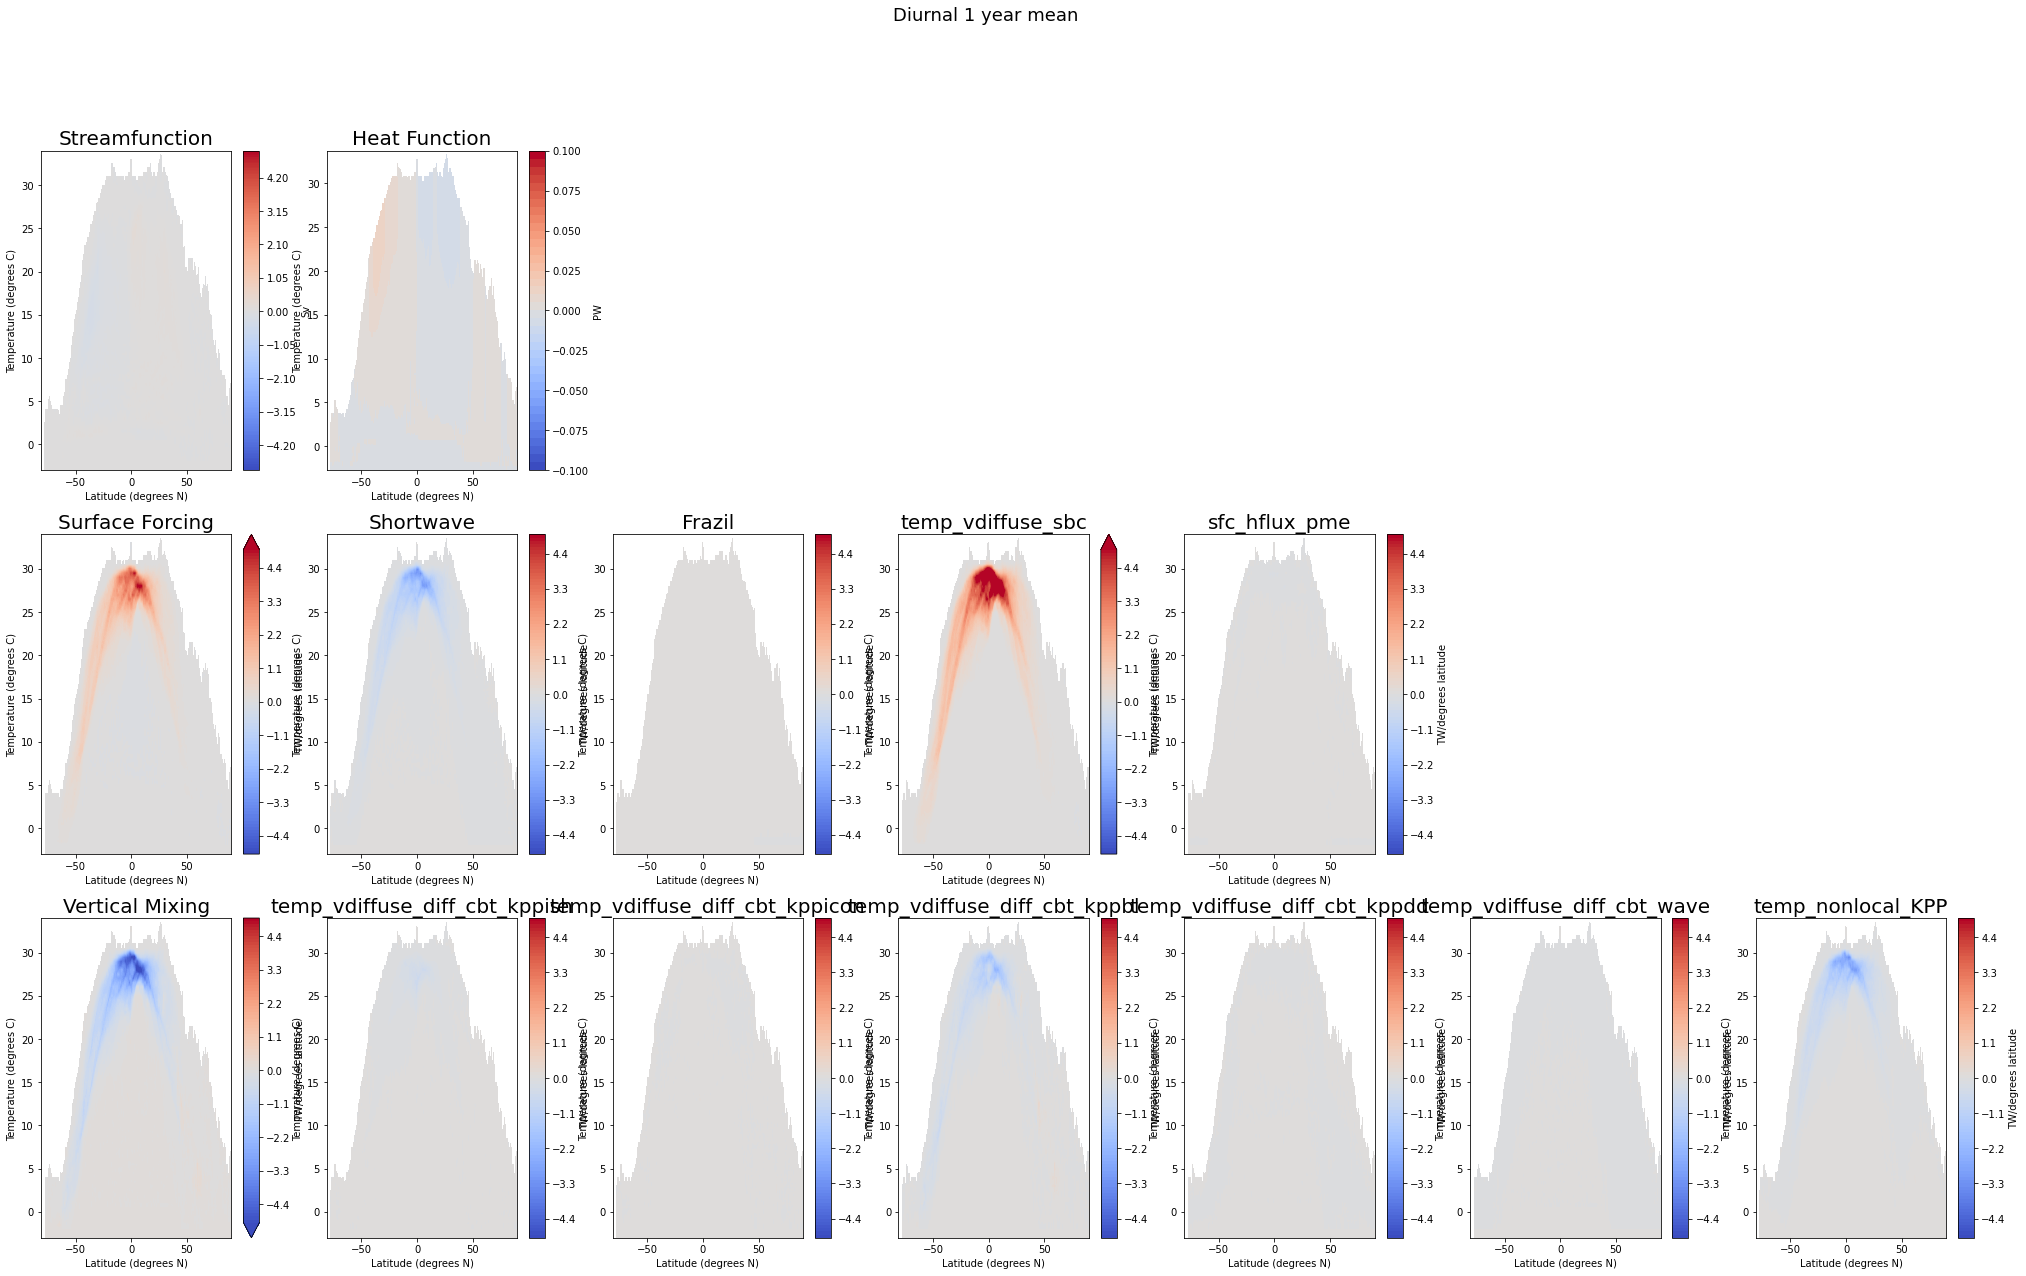

In [22]:
DataSet =  True_1year_means - Oneday_mean_1year_means

Hf = -Cp*rho0*dT*gridwm.cumsum(DataSet.Psi,'T',boundary="fill", fill_value=0)

Psicbar = np.arange(-5.,5.1,0.05)
Hfcbar = np.arange(-0.1,0.105,0.005)
SFcbar = np.arange(-5.,5.1,0.1)
MXcbar = np.arange(-2.5,2.51,0.1)

plot_decomp_3d_to_2d(DataSet, Psicbar, Hfcbar, MXcbar, 'Diurnal 1 year mean')

## Integrate in latitude direction:

In [38]:
def plot_decomp_diathermalHT_3d_to_1d(DataSet, title):

    # Totals in temperature and meridional directions:
    plt.figure(figsize=(14,5))

    plt.subplot()
    (DataSet.SF.sum('grid_xt_ocean')/1.e15).sum('grid_yt_ocean').plot(label='Surface Forcing',color='C0',linewidth=4)
    (DataSet.sw_heat.sum('grid_xt_ocean')/1.e15).sum('grid_yt_ocean').plot(label='Shortwave',color='C1',linewidth=2)
    ((DataSet.SF-DataSet.sw_heat).sum('grid_xt_ocean')/1.e15).sum('grid_yt_ocean').plot(label='vdiffuse_sbc+frazil+pme',color='C2',linewidth=2)
    
    (DataSet.MX.sum('grid_xt_ocean')/1.e15).sum('grid_yt_ocean').plot(label='Vertical Mixing',color='C3',linestyle='dashed',linewidth=4)
    (DataSet.temp_vdiffuse_diff_cbt_kppish.sum('grid_xt_ocean')/1.e15).sum('grid_yt_ocean').plot(label='temp_vdiffuse_diff_cbt_kppish',color='C4',linestyle='dashed',linewidth=2)
    (DataSet.temp_vdiffuse_diff_cbt_kppicon.sum('grid_xt_ocean')/1.e15).sum('grid_yt_ocean').plot(label='temp_vdiffuse_diff_cbt_kppicon',color='C5',linestyle='dashed',linewidth=2)
    (DataSet.temp_vdiffuse_diff_cbt_kppbl.sum('grid_xt_ocean')/1.e15).sum('grid_yt_ocean').plot(label='temp_vdiffuse_diff_cbt_kppbl',color='C6',linestyle='dashed',linewidth=2)
    (DataSet.temp_vdiffuse_diff_cbt_kppdd.sum('grid_xt_ocean')/1.e15).sum('grid_yt_ocean').plot(label='temp_vdiffuse_diff_cbt_kppdd',color='C7',linestyle='dashed',linewidth=2)
    (DataSet.temp_vdiffuse_diff_cbt_wave.sum('grid_xt_ocean')/1.e15).sum('grid_yt_ocean').plot(label='temp_vdiffuse_diff_cbt_wave',color='C8',linestyle='dashed',linewidth=2)
    temp = DataSet.MX-DataSet.temp_vdiffuse_diff_cbt_wave-DataSet.temp_vdiffuse_diff_cbt_kppdd - \
           DataSet.temp_vdiffuse_diff_cbt_kppbl - DataSet.temp_vdiffuse_diff_cbt_kppicon - \
           DataSet.temp_vdiffuse_diff_cbt_kppish
    (temp.sum('grid_xt_ocean')/1.e15).sum('grid_yt_ocean').plot(label='temp_nonlocal_KPP',color='C9',linestyle='dashed',linewidth=2)

    plt.legend(bbox_to_anchor = (1,1),loc='upper left', fontsize = 13)
    plt.ylabel('Diathermal Heat Transport (PW)')
    plt.xlabel('Temperature (degrees C)')
    plt.title('Diathermal Heat Transport', fontsize = 18)
    plt.grid()
    plt.xlim([-3.,31.])
    plt.suptitle(title)
    plt.tight_layout()
    plt.subplots_adjust(right = 0.75)
    plt.show()

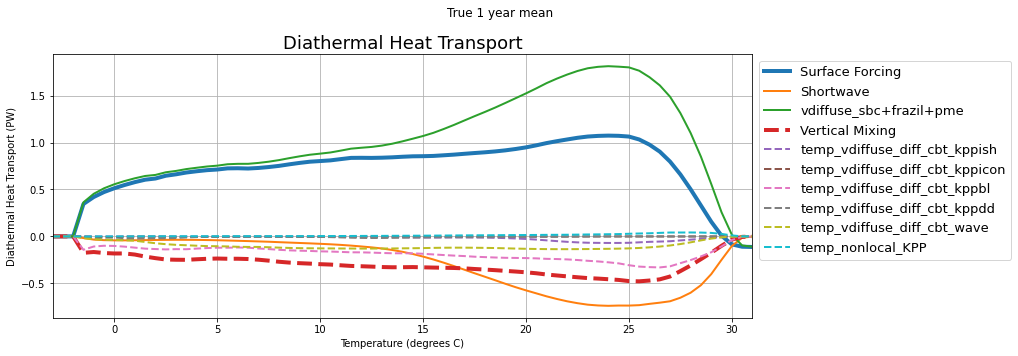

In [39]:
plot_decomp_diathermalHT_3d_to_1d(True_1year_means, 'True 1 year mean')

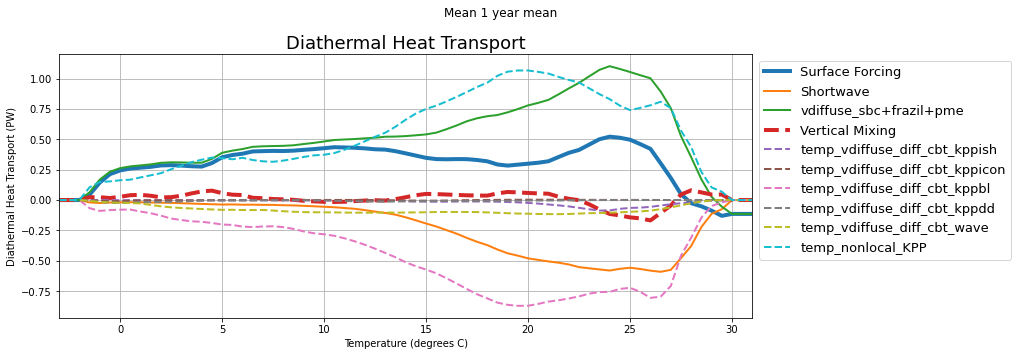

In [40]:
plot_decomp_diathermalHT_3d_to_1d(Mean_1year_means, 'Mean 1 year mean')

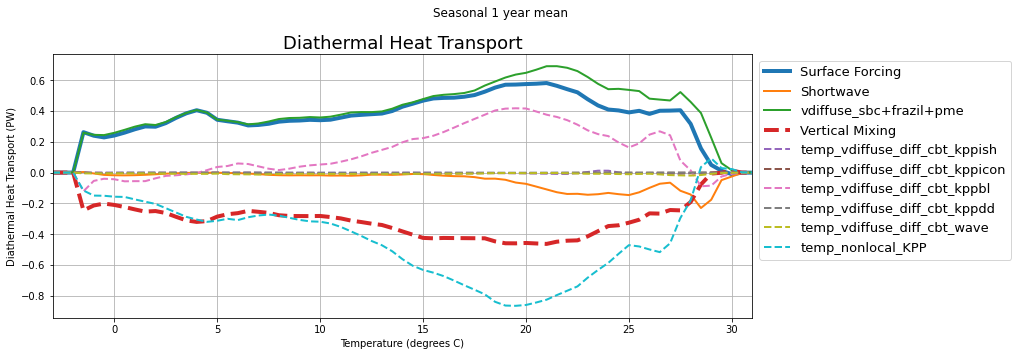

In [41]:
plot_decomp_diathermalHT_3d_to_1d(Twomo_mean_1year_means - Mean_1year_means, 'Seasonal 1 year mean')

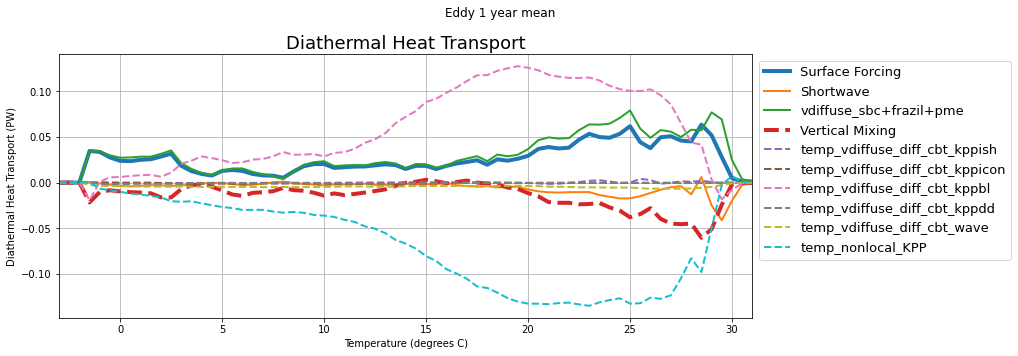

In [44]:
plot_decomp_diathermalHT_3d_to_1d(Tenday_mean_1year_means - Twomo_mean_1year_means, 'Eddy 1 year mean')

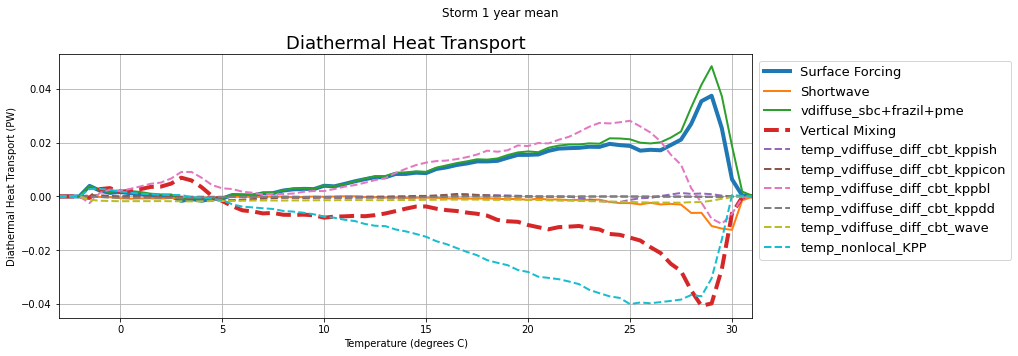

In [103]:
plot_decomp_diathermalHT_3d_to_1d(Oneday_mean_1year_means- Tenday_mean_1year_means , 'Storm 1 year mean')

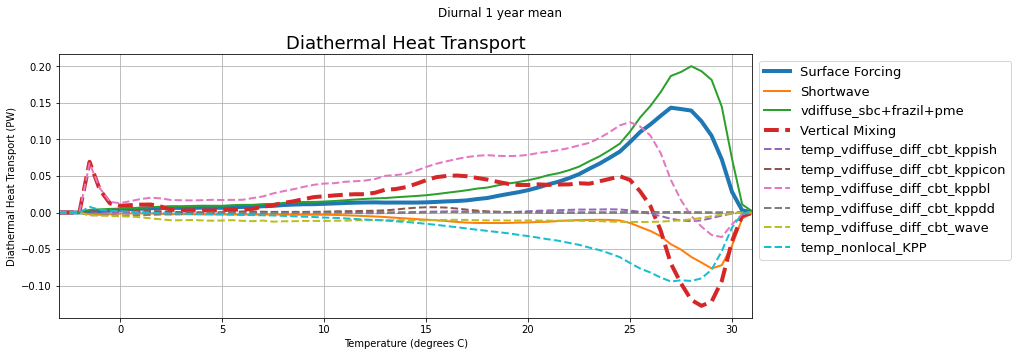

In [104]:
plot_decomp_diathermalHT_3d_to_1d(True_1year_means-Oneday_mean_1year_means , 'Diurnal 1 year mean')

## Spatial Maps Integrated Over Temperature

In [61]:
def plot_decomp_map(DataSet, Psicbar, Hfcbar, SFcbar, MXcbar, SFcbar2, MXcbar2, title):
    
    plt.figure(figsize=(50,15),facecolor='w')
    Hf = -Cp*rho0*dT*gridwm.cumsum(DataSet.Psi,'T',boundary="fill", fill_value=0)

    plt.subplot(3,7,8)
    (DataSet.SF.sum('neutralrho_edges')/1.e12).plot.contourf(levels=SFcbar,y='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('Surface Forcing', fontsize = 20)
    plt.ylabel('Latitude (degrees N)')
    plt.xlabel('Longitude (degrees E)')

    plt.subplot(3,7,9)
    (DataSet.temp_vdiffuse_sbc.sum('neutralrho_edges')/1.e12).plot.contourf(levels=SFcbar,y='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('temp_vdiffuse_sbc', fontsize = 20)
    plt.ylabel('Latitude (degrees N)')
    plt.xlabel('Longitude (degrees E)')

    plt.subplot(3,7,10)
    (DataSet.sw_heat.sum('neutralrho_edges')/1.e12).plot.contourf(levels=SFcbar2,y='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('Shortwave', fontsize = 20)
    plt.ylabel('Latitude (degrees N)')
    plt.xlabel('Longitude (degrees E)')

    plt.subplot(3,7,11)
    (DataSet.frazil_3d.sum('neutralrho_edges')/1.e12).plot.contourf(levels=SFcbar2,y='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('Frazil', fontsize = 20)
    plt.ylabel('Latitude (degrees N)')
    plt.xlabel('Longitude (degrees E)')

    plt.subplot(3,7,12)
    ((DataSet.SF-DataSet.sw_heat-DataSet.frazil_3d-DataSet.temp_vdiffuse_sbc).sum('neutralrho_edges')/1.e12).plot.contourf(levels=SFcbar2,y='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('sfc_hflux_pme', fontsize = 20)
    plt.ylabel('Latitude (degrees N)')
    plt.xlabel('Longitude (degrees E)')

    
    plt.subplot(3,7,15)
    ((DataSet.MX).sum('neutralrho_edges')/1.e12).plot.contourf(levels=MXcbar,y='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('Vertical Mixing', fontsize = 20)
    plt.ylabel('Latitude (degrees N)')
    plt.xlabel('Longitude (degrees E)')

    plt.subplot(3,7,16)
    ((DataSet.temp_vdiffuse_diff_cbt_kppbl).sum('neutralrho_edges')/1.e12).plot.contourf(levels=MXcbar,y='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('temp_vdiffuse_diff_cbt_kppbl', fontsize = 20)
    plt.ylabel('Latitude (degrees N)')
    plt.xlabel('Longitude (degrees E)')

    plt.subplot(3,7,17)
    temp = DataSet.MX-DataSet.temp_vdiffuse_diff_cbt_wave-DataSet.temp_vdiffuse_diff_cbt_kppdd - \
           DataSet.temp_vdiffuse_diff_cbt_kppbl - DataSet.temp_vdiffuse_diff_cbt_kppicon - \
           DataSet.temp_vdiffuse_diff_cbt_kppish
    ((temp).sum('neutralrho_edges')/1.e12).plot.contourf(levels=MXcbar,y='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('temp_nonlocal_KPP', fontsize = 20)
    plt.ylabel('Latitude (degrees N)')
    plt.xlabel('Longitude (degrees E)')

    plt.subplot(3,7,18)
    ((DataSet.temp_vdiffuse_diff_cbt_kppish).sum('neutralrho_edges')/1.e12).plot.contourf(levels=MXcbar2,y='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('temp_vdiffuse_diff_cbt_kppish', fontsize = 20)
    plt.ylabel('Latitude (degrees N)')
    plt.xlabel('Longitude (degrees E)')

    plt.subplot(3,7,19)
    ((DataSet.temp_vdiffuse_diff_cbt_kppicon).sum('neutralrho_edges')/1.e12).plot.contourf(levels=MXcbar2,y='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('temp_vdiffuse_diff_cbt_kppicon', fontsize = 20)
    plt.ylabel('Latitude (degrees N)')
    plt.xlabel('Longitude (degrees E)')


    plt.subplot(3,7,20)
    ((DataSet.temp_vdiffuse_diff_cbt_kppdd).sum('neutralrho_edges')/1.e12).plot.contourf(levels=MXcbar2,y='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('temp_vdiffuse_diff_cbt_kppdd', fontsize = 20)
    plt.ylabel('Latitude (degrees N)')
    plt.xlabel('Longitude (degrees E)')

    plt.subplot(3,7,21)
    ((DataSet.temp_vdiffuse_diff_cbt_wave).sum('neutralrho_edges')/1.e12).plot.contourf(levels=MXcbar2,y='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('temp_vdiffuse_diff_cbt_wave', fontsize = 20)
    plt.ylabel('Latitude (degrees N)')
    plt.xlabel('Longitude (degrees E)')

    
    
    plt.suptitle(title, fontsize = 18)
    plt.show()

## Plot integral from $\Theta$ to $\infty$

$\int_\Theta^\infty = \int_{-\infty}^\infty + \int^{-\infty}_\Theta = \int_{-\infty}^\infty - \int_{-\infty}^\Theta $

In [46]:
def cumsum(var):
    return var.sum('neutralrho_edges') - gridwm.cumsum((var), 'T',boundary="fill",fill_value=0)

In [59]:
def plot_decomp_3d_to_2d_cumsum(DataSet, Psicbar, Hfcbar, MXcbar, title):
    
    plt.figure(figsize=(35,20),facecolor='w')
    Hf = -Cp*rho0*dT*gridwm.cumsum(DataSet.Psi,'T',boundary="fill", fill_value=0)

    plt.subplot(3,7,8)
    (cumsum(DataSet.SF.sum('grid_xt_ocean'))/1.e12/dy).plot.contourf(levels=SFcbar,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('Surface Forcing', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    plt.subplot(3,7,9)
    (cumsum(DataSet.sw_heat.sum('grid_xt_ocean'))/1.e12/dy).plot.contourf(levels=SFcbar,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('Shortwave', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    plt.subplot(3,7,10)
    (cumsum(DataSet.frazil_3d.sum('grid_xt_ocean'))/1.e12/dy).plot.contourf(levels=SFcbar,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('Frazil', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    plt.subplot(3,7,11)
    (cumsum(DataSet.temp_vdiffuse_sbc.sum('grid_xt_ocean'))/1.e12/dy).plot.contourf(levels=SFcbar,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('temp_vdiffuse_sbc', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    plt.subplot(3,7,12)
    (cumsum(DataSet.SF-DataSet.sw_heat-DataSet.frazil_3d-DataSet.temp_vdiffuse_sbc).sum('grid_xt_ocean')/1.e12/dy).plot.contourf(levels=SFcbar,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('sfc_hflux_pme', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    
    plt.subplot(3,7,15)
    (cumsum(DataSet.MX.sum('grid_xt_ocean'))/1.e12/dy).plot.contourf(levels=SFcbar,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('Vertical Mixing', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    plt.subplot(3,7,16)
    (cumsum(DataSet.temp_vdiffuse_diff_cbt_kppish.sum('grid_xt_ocean'))/1.e12/dy).plot.contourf(levels=SFcbar,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('temp_vdiffuse_diff_cbt_kppish', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    plt.subplot(3,7,17)
    (cumsum(DataSet.temp_vdiffuse_diff_cbt_kppicon.sum('grid_xt_ocean'))/1.e12/dy).plot.contourf(levels=SFcbar,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('temp_vdiffuse_diff_cbt_kppicon', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    plt.subplot(3,7,18)
    (cumsum(DataSet.temp_vdiffuse_diff_cbt_kppbl.sum('grid_xt_ocean'))/1.e12/dy).plot.contourf(levels=SFcbar,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('temp_vdiffuse_diff_cbt_kppbl', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    plt.subplot(3,7,19)
    (cumsum(DataSet.temp_vdiffuse_diff_cbt_kppdd.sum('grid_xt_ocean'))/1.e12/dy).plot.contourf(levels=SFcbar,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('temp_vdiffuse_diff_cbt_kppdd', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    plt.subplot(3,7,20)
    (cumsum(DataSet.temp_vdiffuse_diff_cbt_wave.sum('grid_xt_ocean'))/1.e12/dy).plot.contourf(levels=SFcbar,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('temp_vdiffuse_diff_cbt_wave', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    plt.subplot(3,7,21)
    temp = DataSet.MX-DataSet.temp_vdiffuse_diff_cbt_wave-DataSet.temp_vdiffuse_diff_cbt_kppdd - \
           DataSet.temp_vdiffuse_diff_cbt_kppbl - DataSet.temp_vdiffuse_diff_cbt_kppicon - \
           DataSet.temp_vdiffuse_diff_cbt_kppish
    (cumsum(temp.sum('grid_xt_ocean'))/1.e12/dy).plot.contourf(levels=SFcbar,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('temp_nonlocal_KPP', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')
    
    
    plt.suptitle(title, fontsize = 18)
    plt.show()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
2022-05-04 10:32:31,131 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 22.28 GiB -- Worker memory limit: 31.25 GiB
2022-05-04 10:32:31,188 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 22.28 GiB -- Worker memory limit: 31.25 GiB
2022-05-04 10:32:31,288 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may

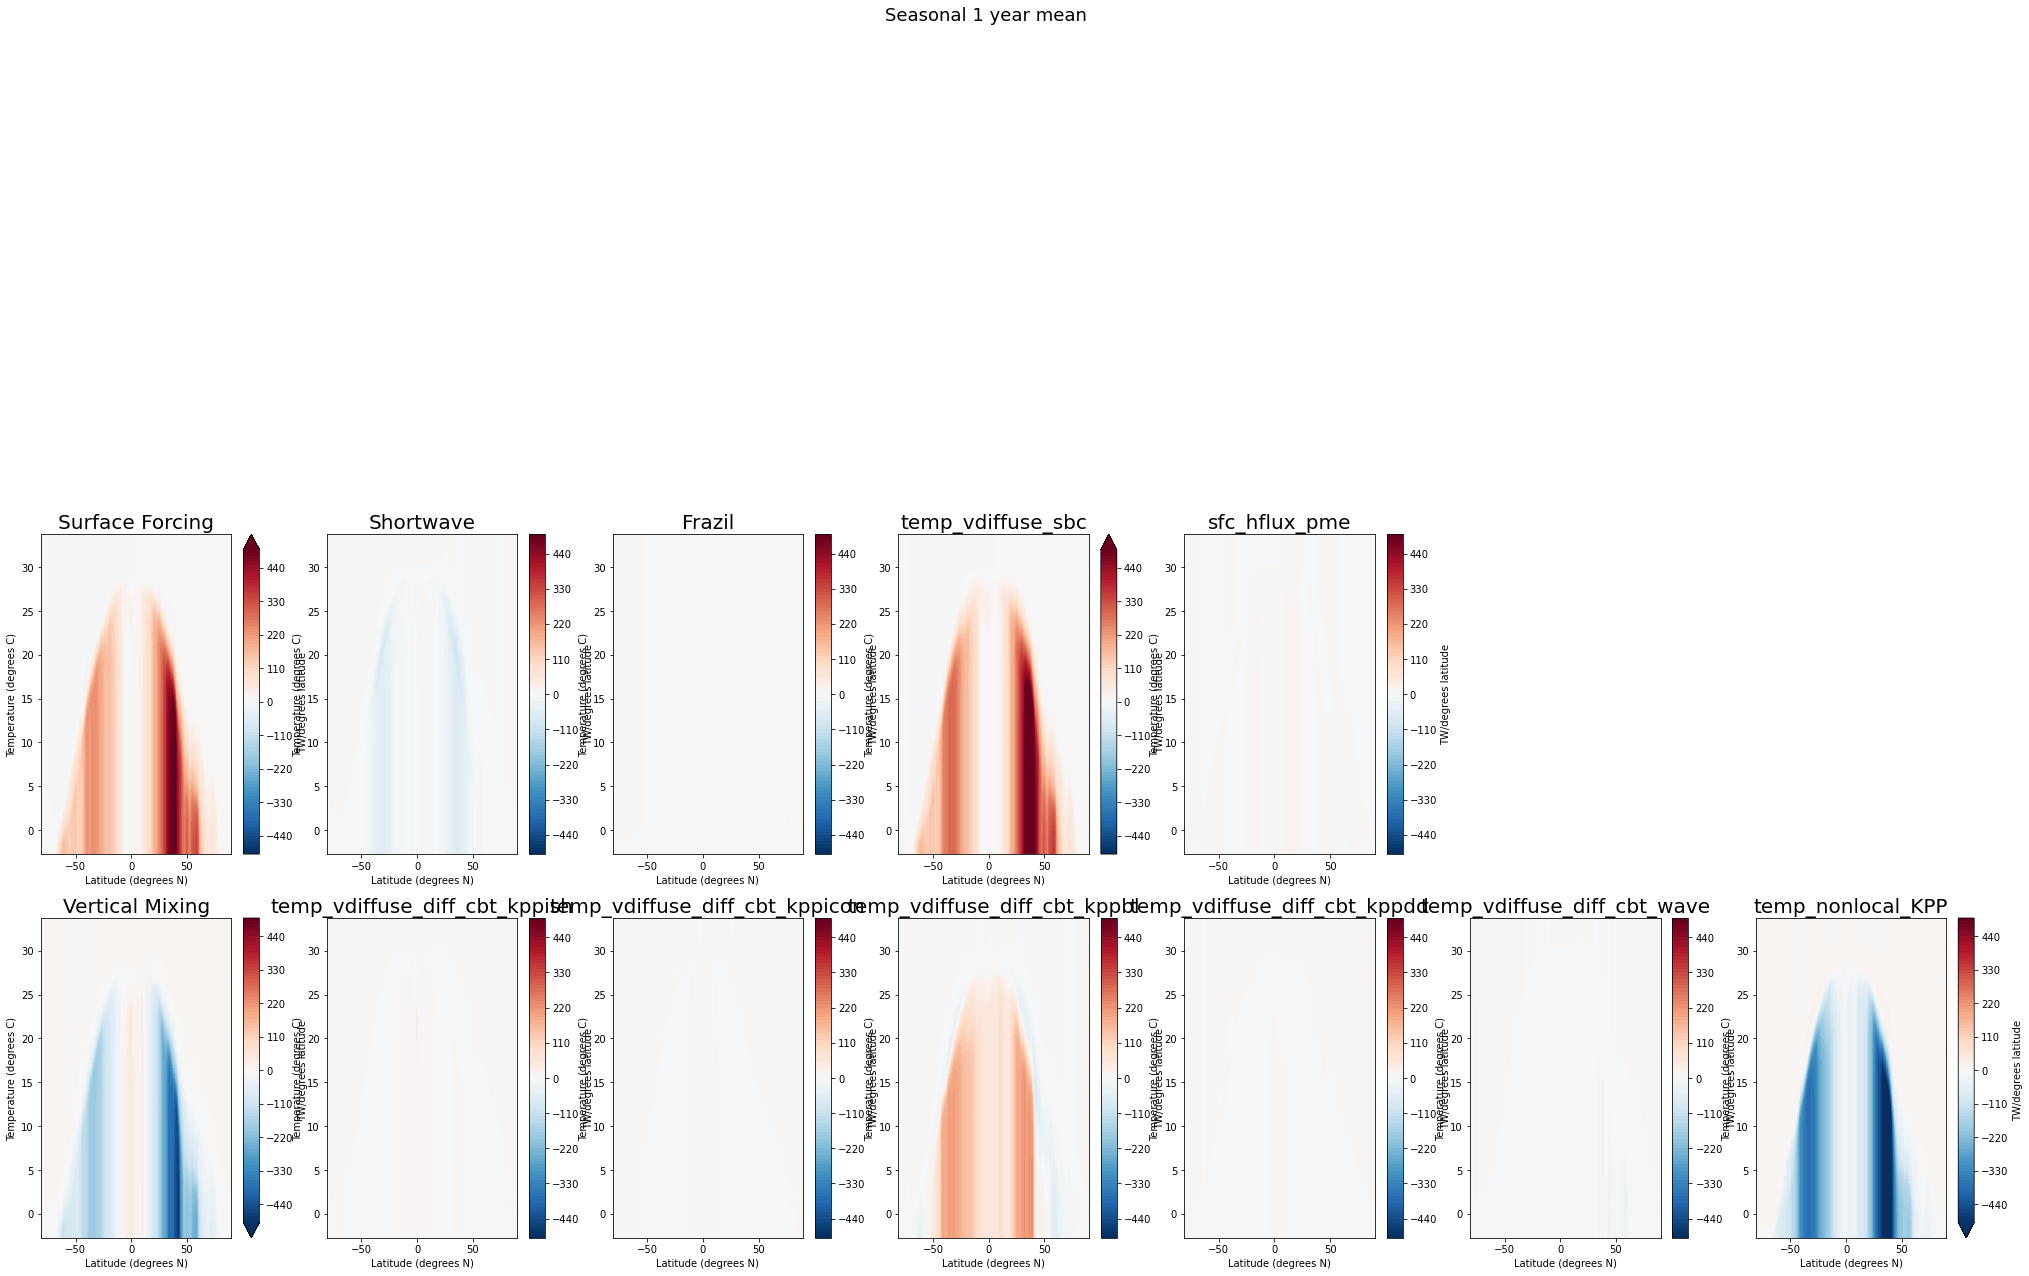

In [64]:
DataSet = Twomo_mean_1year_means - Mean_1year_means

Psicbar = np.arange(-24.,24.5,0.5)
Hfcbar = np.arange(-1.,1.05,0.05)
SFcbar = np.arange(-50.,51.,1.)*10
MXcbar = np.arange(-25.,25.,1.)*10

cmap = 'RdBu_r'

plot_decomp_3d_to_2d_cumsum(DataSet, Psicbar, Hfcbar, MXcbar, 'Seasonal 1 year mean')

2022-05-04 10:26:04,003 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 22.28 GiB -- Worker memory limit: 31.25 GiB
2022-05-04 10:26:04,005 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 22.28 GiB -- Worker memory limit: 31.25 GiB
2022-05-04 10:26:04,088 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 22.28 GiB -- Worker memory limit: 31.25 GiB
2022-05-04 10:26:04,188 - distributed

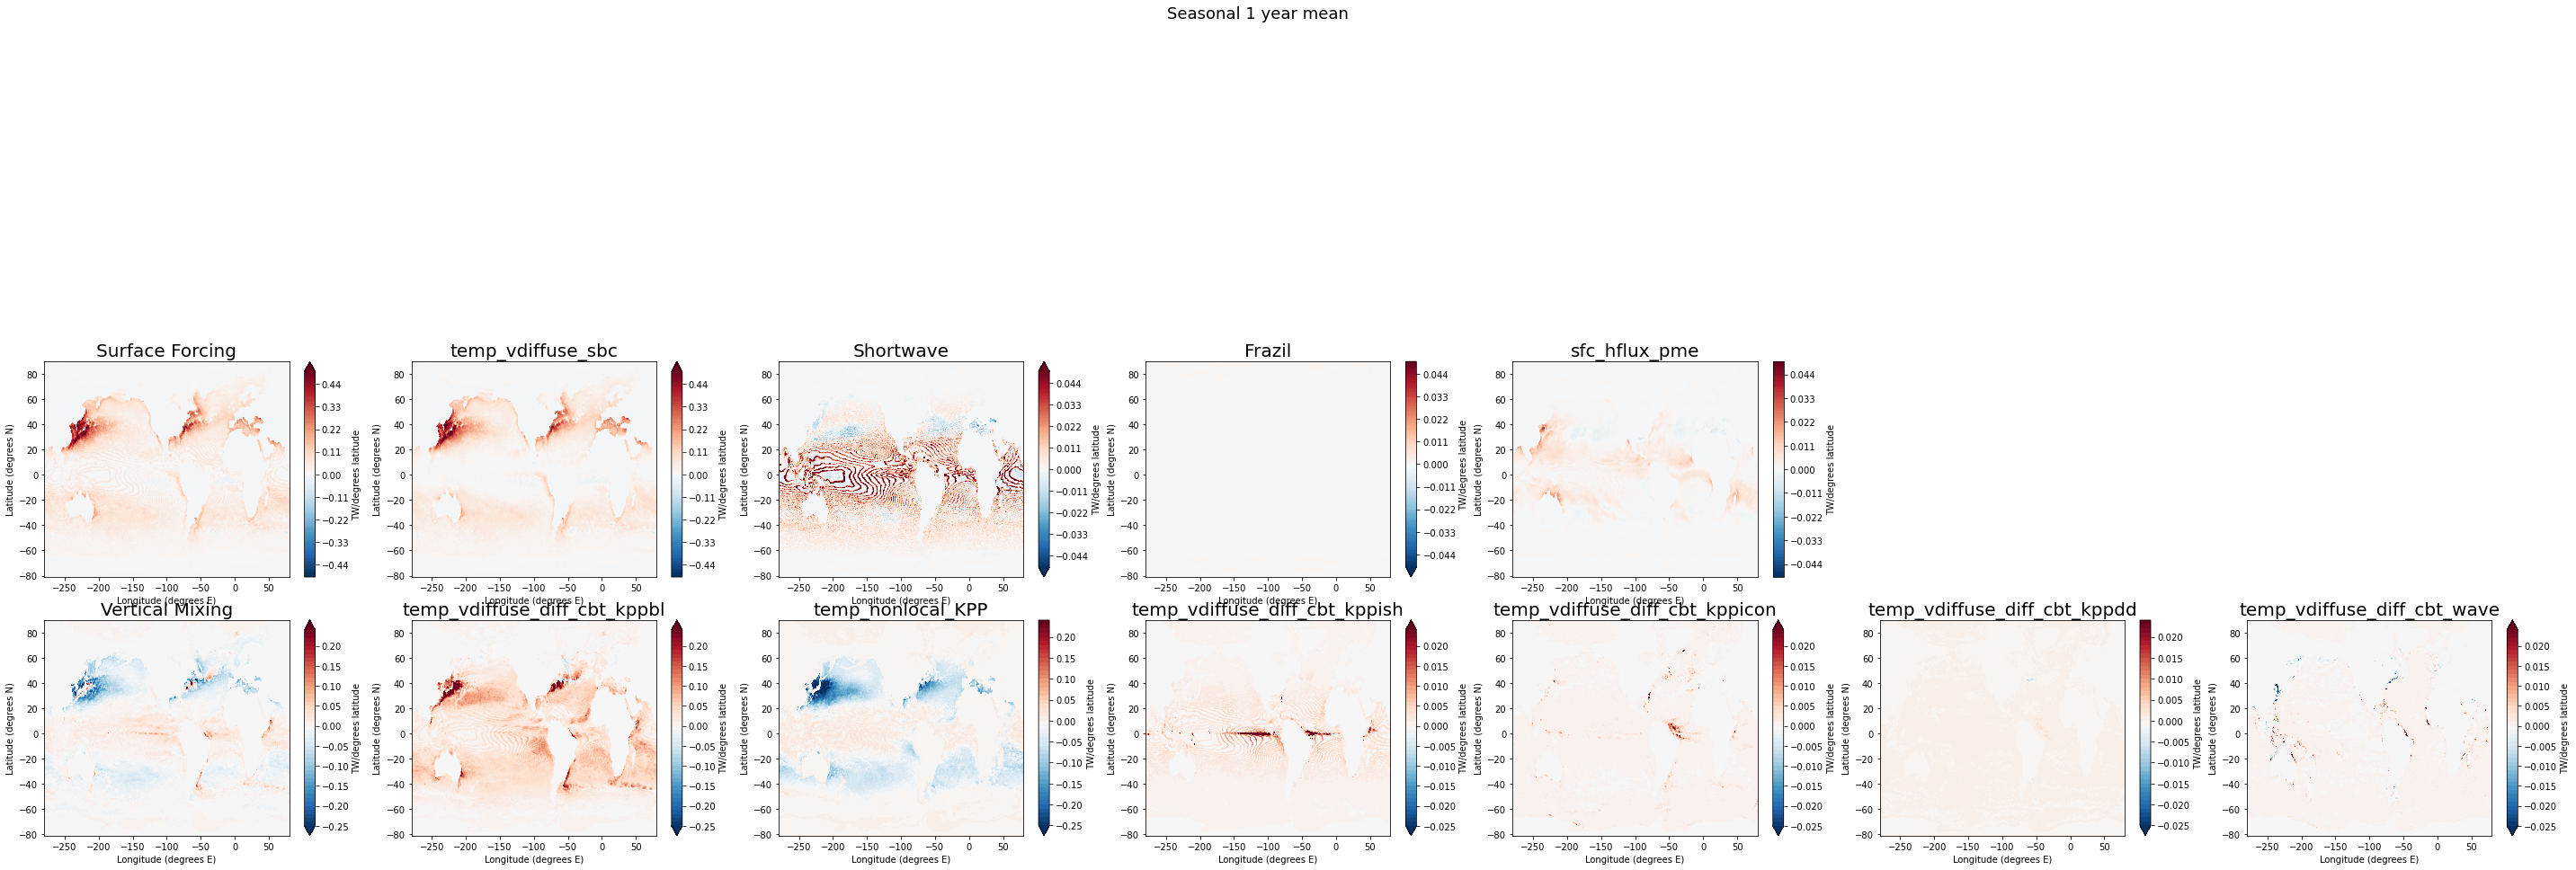

In [63]:
DataSet = Twomo_mean_1year_means - Mean_1year_means

Psicbar = np.arange(-24.,24.5,0.5)
Hfcbar = np.arange(-1.,1.05,0.05)
SFcbar = np.arange(-50.,51.,1.)/100
MXcbar = np.arange(-25.,25.,1.)/100

cmap = 'RdBu_r'

plot_decomp_map(DataSet, Psicbar, Hfcbar, SFcbar, MXcbar, SFcbar/10, MXcbar/10,'Seasonal 1 year mean')

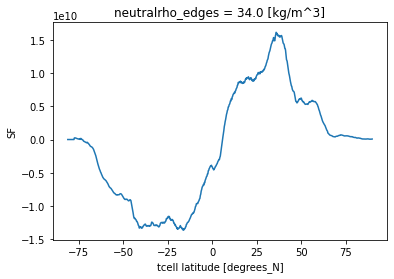

In [72]:
DataSet = Twomo_mean_1year_means - Mean_1year_means
DataSet.SF.isel(neutralrho_edges = -1).sum('grid_xt_ocean').plot()

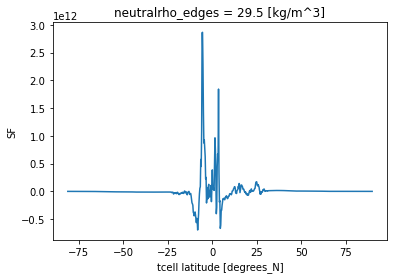

In [73]:
DataSet.SF.isel(neutralrho_edges = -10).sum('grid_xt_ocean').plot()